# Fachprojekt Machine Learning
**Authors:** Anastasiia Korzhylova, Ivan Shishkin, Ramneek Agnihotri, Rodi Mehi

**Due date:** Wednesday, 12. June 2024

## Import necessary components

In [1]:
# Import the necessary libraries

import time, warnings
from tabulate import tabulate
import torch, torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR

# Import the VAE model and functions
import networks

from datasets import create_datasets
from evaluation import evaluate
from sampling import sample, plot_reconstruction
from plotting import plot_loss_lr, plot_loss_components

## Set hyperparameters, loss function and optimizing tools

In [2]:
# Hyperparameters
batch_size = 128 # Number of images per update of the network
num_epochs = 100 # One epoch means seeing every image of the training dataset
latent_dim = 256  # Size of the latent space
input_channels = 3  # CIFAR-10 images have 3 color channels
learning_rate = 2e-5 # Determines how drastically the parameters of the network change
output_frequency = 150 # Determines how often the training progress will be logged (in batches)
number_embedding_vectors = 100
embedding_dimension = 128
beta = 0.1
# Select the device that will be used for training: GPU, if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('=========================================')

# Put the neural network on the selected device
model = networks.VQVAE(input_channels=input_channels,emb_dim=embedding_dimension,n_embed=number_embedding_vectors,beta=beta)
model.to(device)

# Optimizer selection
optimizer_option = 'adam'

optimizer = None
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
else:
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Learning rate scheduler parameters
lr_schedule_option = 'exponential'

scheduler = None
if lr_schedule_option == 'step':
  scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
elif lr_schedule_option == 'exponential':
  scheduler = ExponentialLR(optimizer, gamma=0.9)
elif lr_schedule_option == 'cosine':
  scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# Scaler for AMP
scaler = torch.cuda.amp.GradScaler()

Using device: cuda


## Choose a dataset for training

Files already downloaded and verified
Files already downloaded and verified


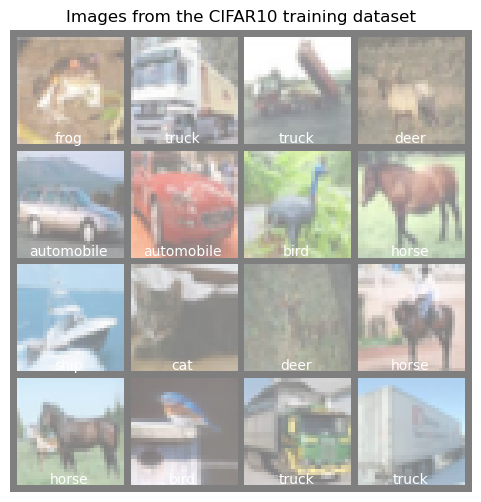

In [3]:
# Create and visualize the datasets for MNIST / CIFAR10
import numpy as np


dataset_name = 'CIFAR10'
train_loader, test_loader = create_datasets(dataset_name, batch_size)


## Training loop

-----------------------------------------------------------------------------------------------------------------------------
Epoch:  1/100  Batch:    1  Total Loss:  45003.2  VQ Loss:  0.792737  Recon Loss:  45002.4  Commitment Loss:  0.72067  Embedding Loss:  0.72067  LR:  2e-05
Epoch:  1/100  Batch:  151  Total Loss:  5579.07  VQ Loss:  1.68868  Recon Loss:  5577.39  Commitment Loss:  1.53516  Embedding Loss:  1.53516  LR:  2e-05
Epoch:  1/100  Batch:  301  Total Loss:  3333.91  VQ Loss:  1.76759  Recon Loss:  3332.14  Commitment Loss:  1.6069  Embedding Loss:  1.6069  LR:  2e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       1 │            2.198 │ 26.37s │
╘═════════╧══════════════════╧════════╛


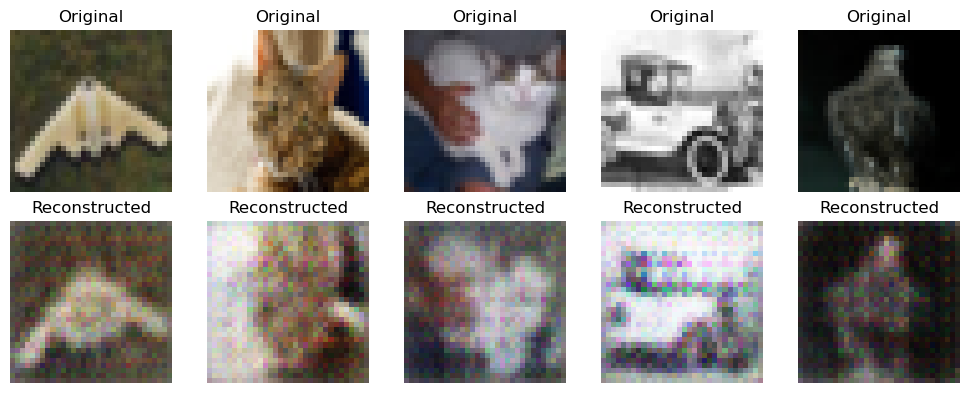

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  2/100  Batch:    1  Total Loss:  2823.17  VQ Loss:  1.82764  Recon Loss:  2821.34  Commitment Loss:  1.66149  Embedding Loss:  1.66149  LR:  1.8e-05
Epoch:  2/100  Batch:  151  Total Loss:  2378.78  VQ Loss:  1.94818  Recon Loss:  2376.83  Commitment Loss:  1.77108  Embedding Loss:  1.77108  LR:  1.8e-05
Epoch:  2/100  Batch:  301  Total Loss:  1994.67  VQ Loss:  1.91556  Recon Loss:  1992.75  Commitment Loss:  1.74142  Embedding Loss:  1.74142  LR:  1.8e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       2 │           2.2063 │ 25.40s │
╘═════════╧══════════════════╧════════╛


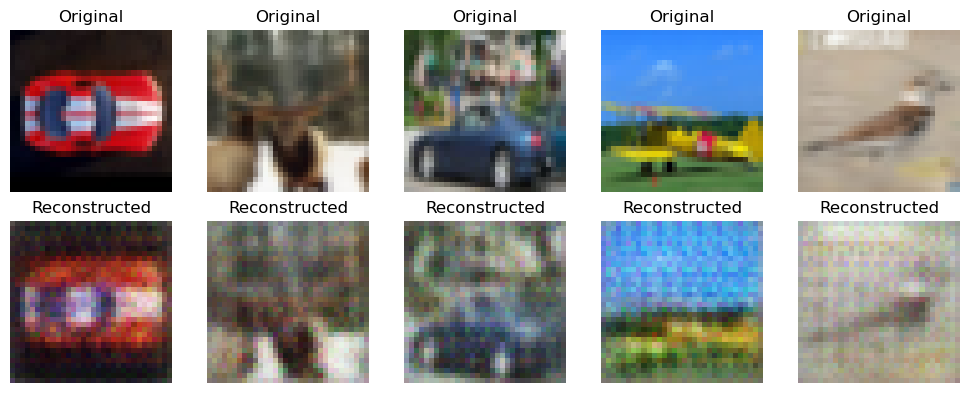

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  3/100  Batch:    1  Total Loss:  1869.41  VQ Loss:  1.9319  Recon Loss:  1867.48  Commitment Loss:  1.75627  Embedding Loss:  1.75627  LR:  1.62e-05
Epoch:  3/100  Batch:  151  Total Loss:  1608.63  VQ Loss:  1.90532  Recon Loss:  1606.73  Commitment Loss:  1.73211  Embedding Loss:  1.73211  LR:  1.62e-05
Epoch:  3/100  Batch:  301  Total Loss:  1660.14  VQ Loss:  1.93685  Recon Loss:  1658.21  Commitment Loss:  1.76077  Embedding Loss:  1.76077  LR:  1.62e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       3 │           2.2106 │ 25.46s │
╘═════════╧══════════════════╧════════╛


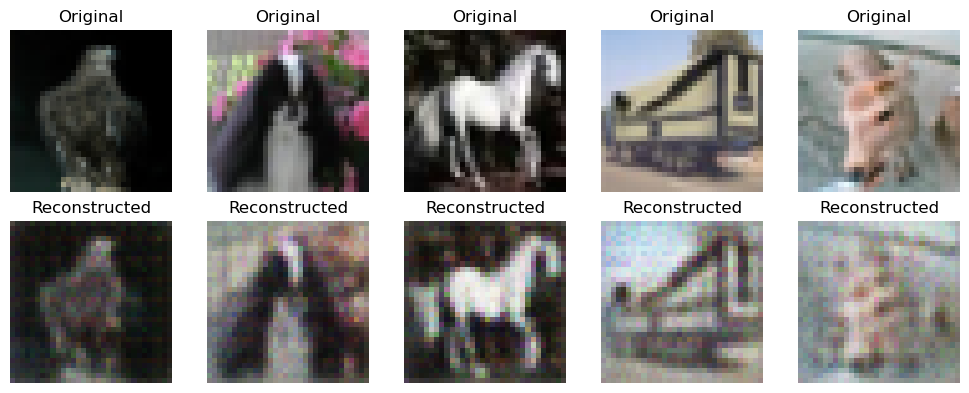

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  4/100  Batch:    1  Total Loss:  1415.57  VQ Loss:  1.98401  Recon Loss:  1413.59  Commitment Loss:  1.80365  Embedding Loss:  1.80365  LR:  1.458e-05
Epoch:  4/100  Batch:  151  Total Loss:  1318.6  VQ Loss:  1.93455  Recon Loss:  1316.66  Commitment Loss:  1.75868  Embedding Loss:  1.75868  LR:  1.458e-05
Epoch:  4/100  Batch:  301  Total Loss:  1239.52  VQ Loss:  1.98634  Recon Loss:  1237.54  Commitment Loss:  1.80577  Embedding Loss:  1.80577  LR:  1.458e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       4 │           2.0193 │ 25.50s │
╘═════════╧══════════════════╧════════╛


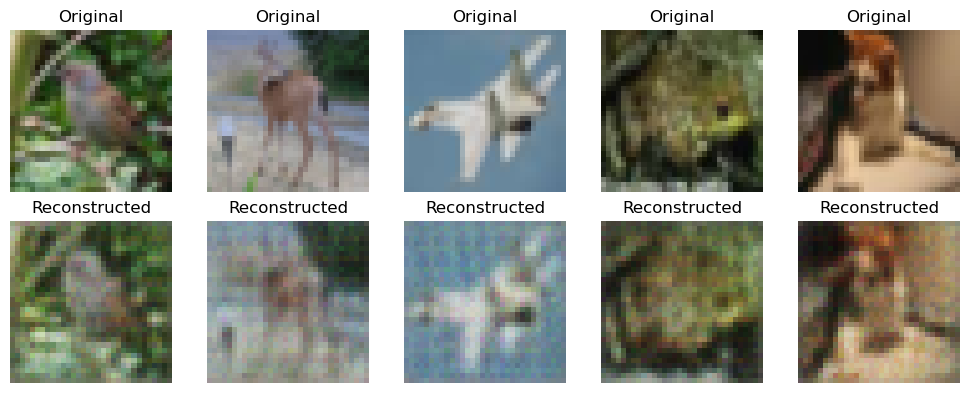

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  5/100  Batch:    1  Total Loss:  1255.62  VQ Loss:  1.93724  Recon Loss:  1253.68  Commitment Loss:  1.76113  Embedding Loss:  1.76113  LR:  1.3122e-05
Epoch:  5/100  Batch:  151  Total Loss:  1277.04  VQ Loss:  1.97251  Recon Loss:  1275.06  Commitment Loss:  1.79319  Embedding Loss:  1.79319  LR:  1.3122e-05
Epoch:  5/100  Batch:  301  Total Loss:  1238.74  VQ Loss:  1.96862  Recon Loss:  1236.77  Commitment Loss:  1.78966  Embedding Loss:  1.78966  LR:  1.3122e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       5 │           2.0403 │ 25.34s │
╘═════════╧══════════════════╧════════╛


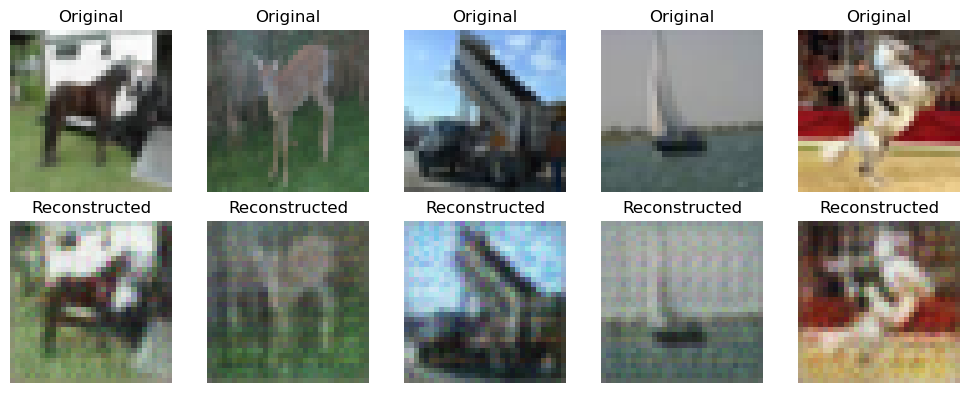

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  6/100  Batch:    1  Total Loss:  1128.82  VQ Loss:  1.98174  Recon Loss:  1126.84  Commitment Loss:  1.80158  Embedding Loss:  1.80158  LR:  1.18098e-05
Epoch:  6/100  Batch:  151  Total Loss:  1069.72  VQ Loss:  1.99003  Recon Loss:  1067.73  Commitment Loss:  1.80912  Embedding Loss:  1.80912  LR:  1.18098e-05
Epoch:  6/100  Batch:  301  Total Loss:  1129.41  VQ Loss:  1.9963  Recon Loss:  1127.42  Commitment Loss:  1.81482  Embedding Loss:  1.81482  LR:  1.18098e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       6 │           2.3809 │ 25.49s │
╘═════════╧══════════════════╧════════╛


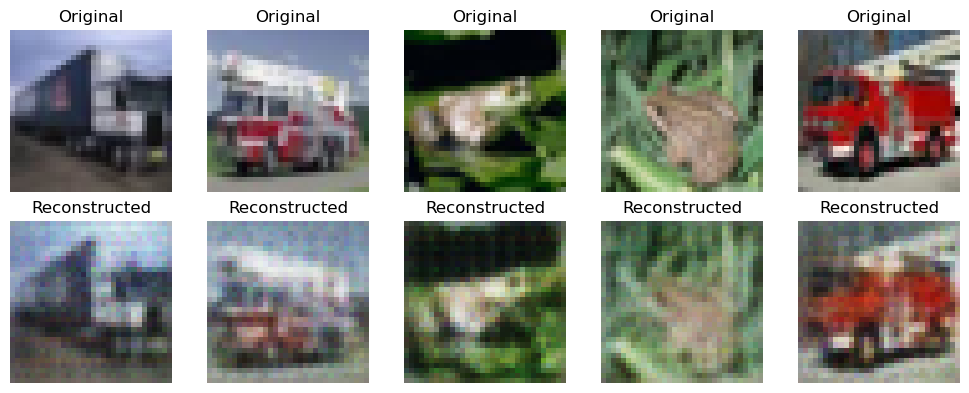

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  7/100  Batch:    1  Total Loss:  1006.45  VQ Loss:  1.98639  Recon Loss:  1004.46  Commitment Loss:  1.80581  Embedding Loss:  1.80581  LR:  1.06288e-05
Epoch:  7/100  Batch:  151  Total Loss:  1013.83  VQ Loss:  1.97636  Recon Loss:  1011.85  Commitment Loss:  1.79669  Embedding Loss:  1.79669  LR:  1.06288e-05
Epoch:  7/100  Batch:  301  Total Loss:  851.947  VQ Loss:  2.04133  Recon Loss:  849.906  Commitment Loss:  1.85575  Embedding Loss:  1.85575  LR:  1.06288e-05
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       7 │           2.0276 │ 22.20s │
╘═════════╧══════════════════╧════════╛


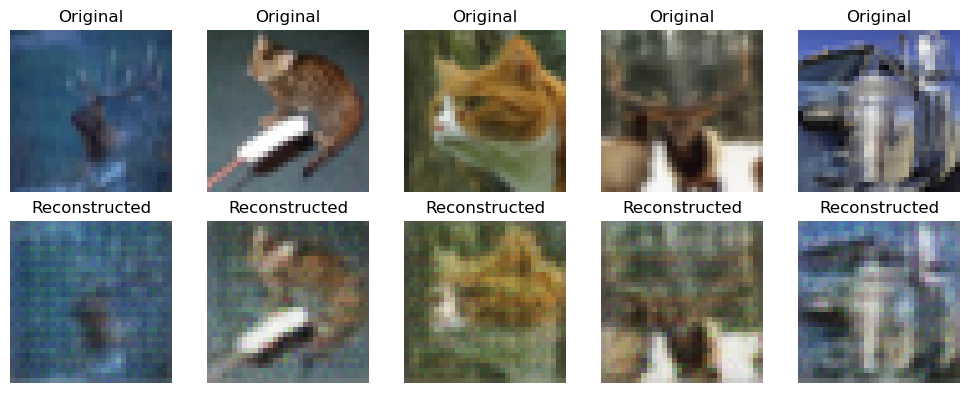

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  8/100  Batch:    1  Total Loss:  905.636  VQ Loss:  1.99175  Recon Loss:  903.645  Commitment Loss:  1.81069  Embedding Loss:  1.81069  LR:  9.56594e-06
Epoch:  8/100  Batch:  151  Total Loss:  958.923  VQ Loss:  2.00051  Recon Loss:  956.922  Commitment Loss:  1.81864  Embedding Loss:  1.81864  LR:  9.56594e-06
Epoch:  8/100  Batch:  301  Total Loss:  845.498  VQ Loss:  2.01954  Recon Loss:  843.478  Commitment Loss:  1.83594  Embedding Loss:  1.83594  LR:  9.56594e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       8 │           2.0581 │ 23.68s │
╘═════════╧══════════════════╧════════╛


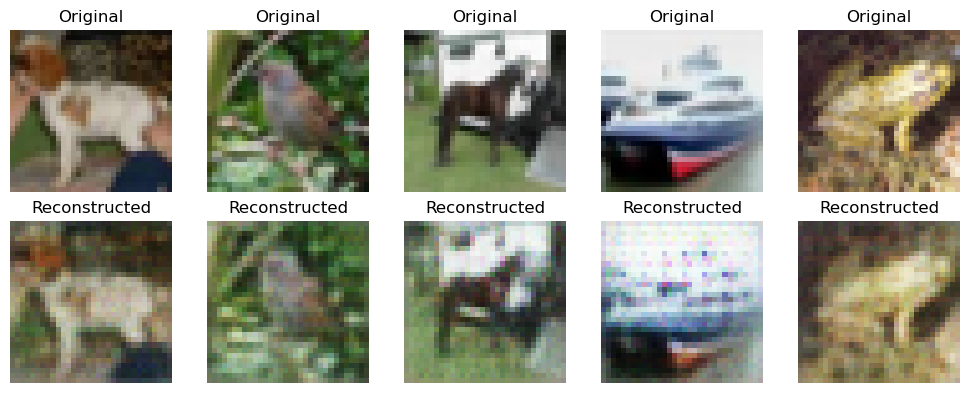

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  9/100  Batch:    1  Total Loss:  795.047  VQ Loss:  2.01917  Recon Loss:  793.027  Commitment Loss:  1.83561  Embedding Loss:  1.83561  LR:  8.60934e-06
Epoch:  9/100  Batch:  151  Total Loss:  845.124  VQ Loss:  1.98179  Recon Loss:  843.143  Commitment Loss:  1.80162  Embedding Loss:  1.80162  LR:  8.60934e-06
Epoch:  9/100  Batch:  301  Total Loss:  945.253  VQ Loss:  1.99183  Recon Loss:  943.262  Commitment Loss:  1.81076  Embedding Loss:  1.81076  LR:  8.60934e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│       9 │           2.0154 │ 25.24s │
╘═════════╧══════════════════╧════════╛


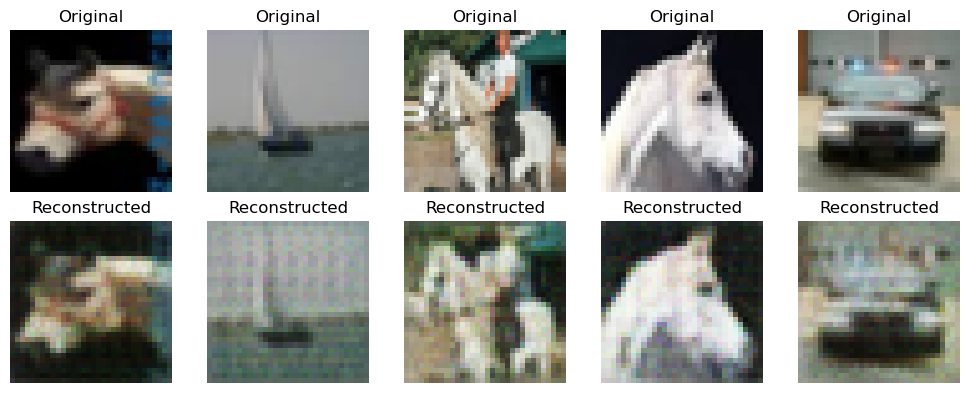

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  10/100  Batch:    1  Total Loss:  800.472  VQ Loss:  1.99691  Recon Loss:  798.475  Commitment Loss:  1.81537  Embedding Loss:  1.81537  LR:  7.74841e-06
Epoch:  10/100  Batch:  151  Total Loss:  872.478  VQ Loss:  2.02264  Recon Loss:  870.455  Commitment Loss:  1.83876  Embedding Loss:  1.83876  LR:  7.74841e-06
Epoch:  10/100  Batch:  301  Total Loss:  823.577  VQ Loss:  2.01333  Recon Loss:  821.564  Commitment Loss:  1.8303  Embedding Loss:  1.8303  LR:  7.74841e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      10 │           2.0315 │ 25.08s │
╘═════════╧══════════════════╧════════╛


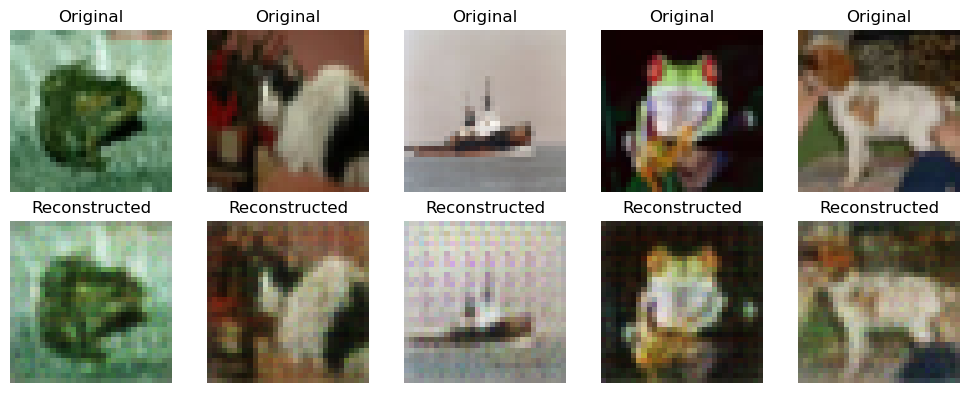

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  11/100  Batch:    1  Total Loss:  922.963  VQ Loss:  1.97912  Recon Loss:  920.984  Commitment Loss:  1.7992  Embedding Loss:  1.7992  LR:  6.97357e-06
Epoch:  11/100  Batch:  151  Total Loss:  812.991  VQ Loss:  1.97467  Recon Loss:  811.016  Commitment Loss:  1.79516  Embedding Loss:  1.79516  LR:  6.97357e-06
Epoch:  11/100  Batch:  301  Total Loss:  799.097  VQ Loss:  1.97371  Recon Loss:  797.123  Commitment Loss:  1.79428  Embedding Loss:  1.79428  LR:  6.97357e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      11 │           1.8831 │ 25.58s │
╘═════════╧══════════════════╧════════╛


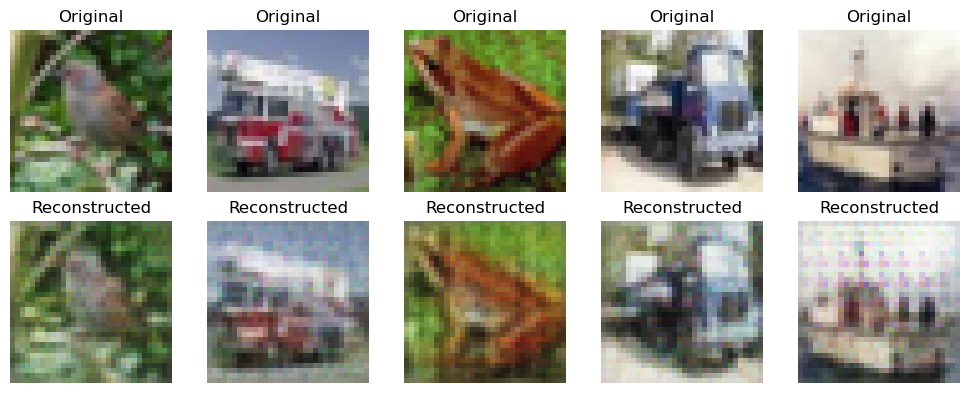

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  12/100  Batch:    1  Total Loss:  697.503  VQ Loss:  1.97295  Recon Loss:  695.53  Commitment Loss:  1.79359  Embedding Loss:  1.79359  LR:  6.27621e-06
Epoch:  12/100  Batch:  151  Total Loss:  704.055  VQ Loss:  1.98224  Recon Loss:  702.072  Commitment Loss:  1.80204  Embedding Loss:  1.80204  LR:  6.27621e-06
Epoch:  12/100  Batch:  301  Total Loss:  707.274  VQ Loss:  1.97666  Recon Loss:  705.297  Commitment Loss:  1.79697  Embedding Loss:  1.79697  LR:  6.27621e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      12 │           2.0527 │ 25.63s │
╘═════════╧══════════════════╧════════╛


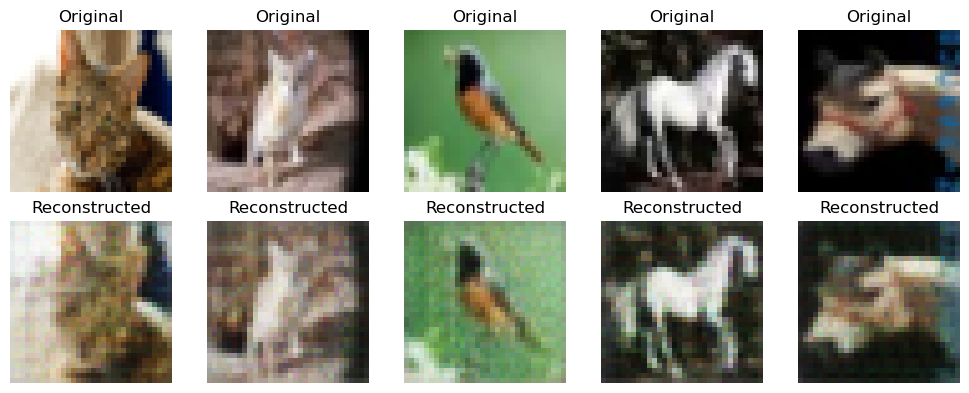

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  13/100  Batch:    1  Total Loss:  670.173  VQ Loss:  1.9684  Recon Loss:  668.204  Commitment Loss:  1.78946  Embedding Loss:  1.78946  LR:  5.64859e-06
Epoch:  13/100  Batch:  151  Total Loss:  692.952  VQ Loss:  1.95731  Recon Loss:  690.994  Commitment Loss:  1.77937  Embedding Loss:  1.77937  LR:  5.64859e-06
Epoch:  13/100  Batch:  301  Total Loss:  786.692  VQ Loss:  2.02068  Recon Loss:  784.672  Commitment Loss:  1.83698  Embedding Loss:  1.83698  LR:  5.64859e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      13 │           2.1529 │ 25.75s │
╘═════════╧══════════════════╧════════╛


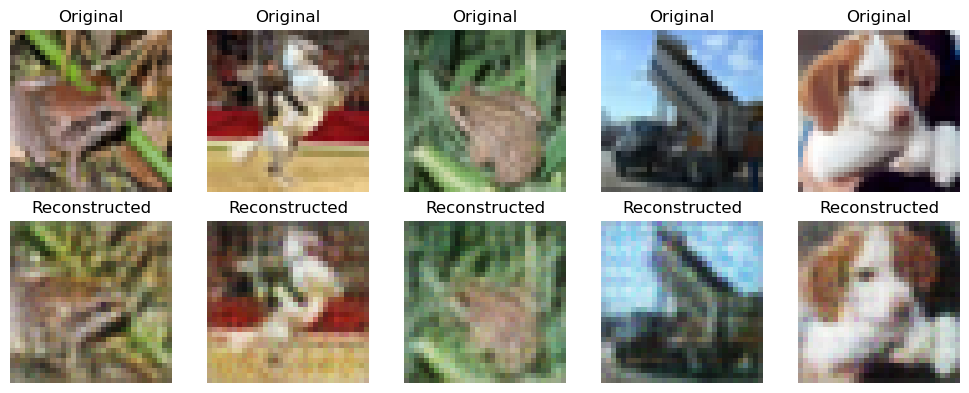

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  14/100  Batch:    1  Total Loss:  657.068  VQ Loss:  1.99684  Recon Loss:  655.071  Commitment Loss:  1.8153  Embedding Loss:  1.8153  LR:  5.08373e-06
Epoch:  14/100  Batch:  151  Total Loss:  695.131  VQ Loss:  1.97993  Recon Loss:  693.151  Commitment Loss:  1.79994  Embedding Loss:  1.79994  LR:  5.08373e-06
Epoch:  14/100  Batch:  301  Total Loss:  645.91  VQ Loss:  1.98825  Recon Loss:  643.922  Commitment Loss:  1.8075  Embedding Loss:  1.8075  LR:  5.08373e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      14 │           2.0019 │ 25.54s │
╘═════════╧══════════════════╧════════╛


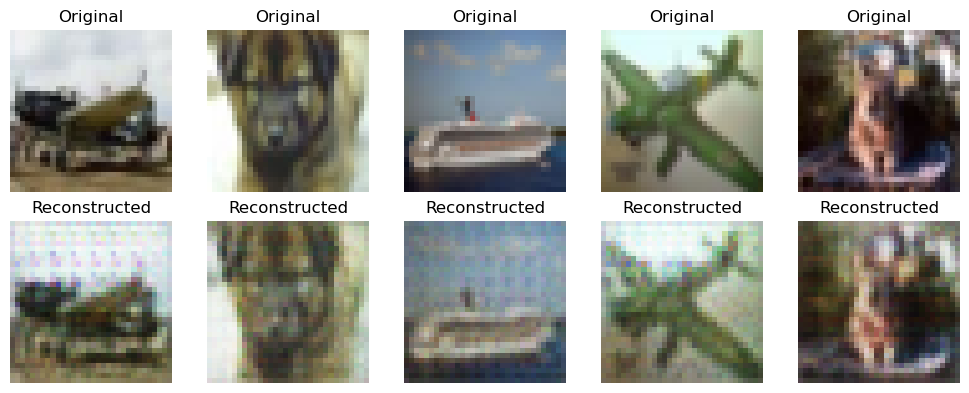

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  15/100  Batch:    1  Total Loss:  665.364  VQ Loss:  1.99602  Recon Loss:  663.368  Commitment Loss:  1.81456  Embedding Loss:  1.81456  LR:  4.57536e-06
Epoch:  15/100  Batch:  151  Total Loss:  768.846  VQ Loss:  1.98724  Recon Loss:  766.859  Commitment Loss:  1.80658  Embedding Loss:  1.80658  LR:  4.57536e-06
Epoch:  15/100  Batch:  301  Total Loss:  654.647  VQ Loss:  1.97779  Recon Loss:  652.669  Commitment Loss:  1.79799  Embedding Loss:  1.79799  LR:  4.57536e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      15 │           1.8418 │ 25.51s │
╘═════════╧══════════════════╧════════╛


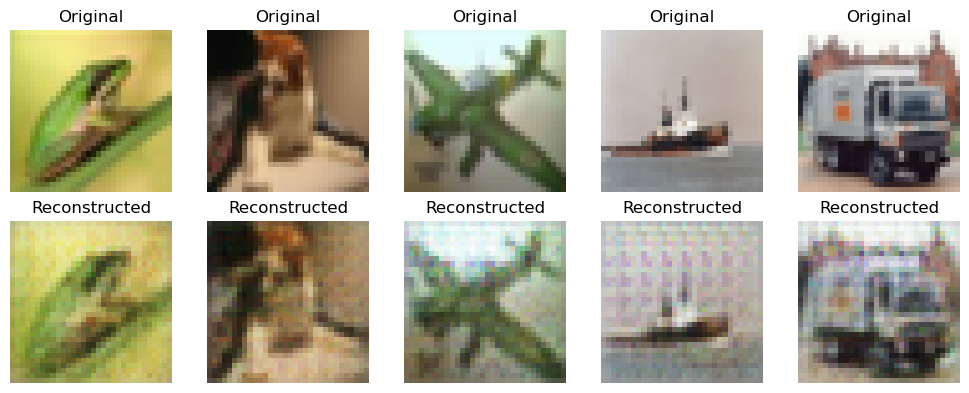

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  16/100  Batch:    1  Total Loss:  682.203  VQ Loss:  1.96792  Recon Loss:  680.235  Commitment Loss:  1.78902  Embedding Loss:  1.78902  LR:  4.11782e-06
Epoch:  16/100  Batch:  151  Total Loss:  649.112  VQ Loss:  1.97249  Recon Loss:  647.14  Commitment Loss:  1.79317  Embedding Loss:  1.79317  LR:  4.11782e-06
Epoch:  16/100  Batch:  301  Total Loss:  749.289  VQ Loss:  1.98087  Recon Loss:  747.308  Commitment Loss:  1.80079  Embedding Loss:  1.80079  LR:  4.11782e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      16 │           1.9476 │ 25.66s │
╘═════════╧══════════════════╧════════╛


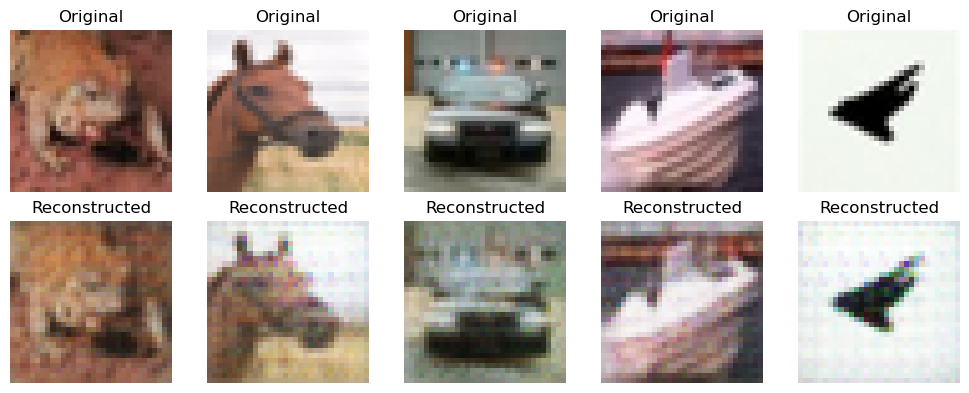

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  17/100  Batch:    1  Total Loss:  795.409  VQ Loss:  2.00267  Recon Loss:  793.406  Commitment Loss:  1.82061  Embedding Loss:  1.82061  LR:  3.70604e-06
Epoch:  17/100  Batch:  151  Total Loss:  622.225  VQ Loss:  1.99442  Recon Loss:  620.231  Commitment Loss:  1.81311  Embedding Loss:  1.81311  LR:  3.70604e-06
Epoch:  17/100  Batch:  301  Total Loss:  608.272  VQ Loss:  1.95749  Recon Loss:  606.314  Commitment Loss:  1.77954  Embedding Loss:  1.77954  LR:  3.70604e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      17 │           2.0411 │ 25.78s │
╘═════════╧══════════════════╧════════╛


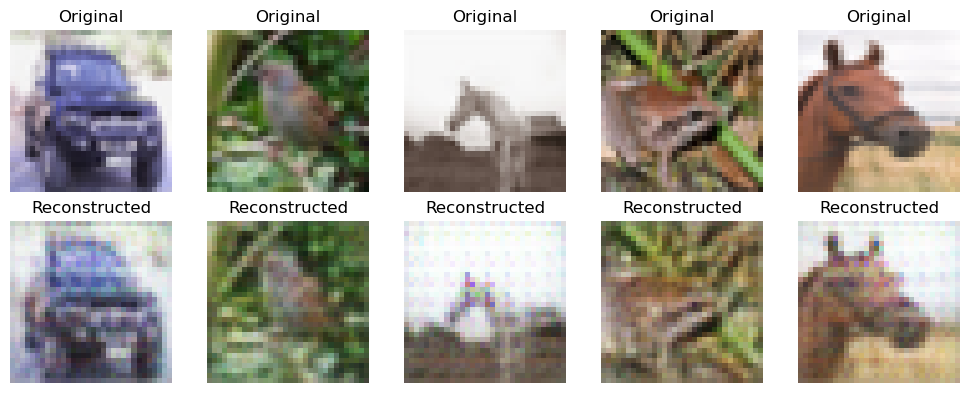

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  18/100  Batch:    1  Total Loss:  663.661  VQ Loss:  1.96947  Recon Loss:  661.692  Commitment Loss:  1.79043  Embedding Loss:  1.79043  LR:  3.33544e-06
Epoch:  18/100  Batch:  151  Total Loss:  613.719  VQ Loss:  1.97468  Recon Loss:  611.744  Commitment Loss:  1.79516  Embedding Loss:  1.79516  LR:  3.33544e-06
Epoch:  18/100  Batch:  301  Total Loss:  571.242  VQ Loss:  1.97504  Recon Loss:  569.267  Commitment Loss:  1.79549  Embedding Loss:  1.79549  LR:  3.33544e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      18 │           2.0426 │ 25.83s │
╘═════════╧══════════════════╧════════╛


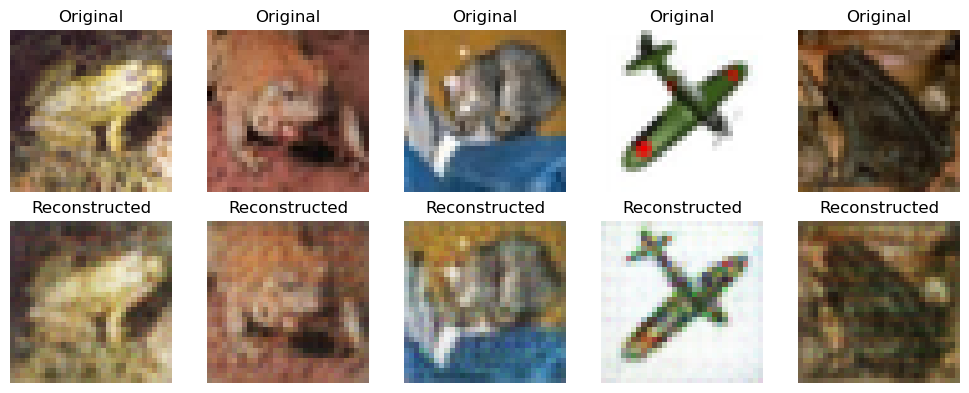

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  19/100  Batch:    1  Total Loss:  682.873  VQ Loss:  1.97588  Recon Loss:  680.897  Commitment Loss:  1.79625  Embedding Loss:  1.79625  LR:  3.00189e-06
Epoch:  19/100  Batch:  151  Total Loss:  592.072  VQ Loss:  1.9596  Recon Loss:  590.112  Commitment Loss:  1.78145  Embedding Loss:  1.78145  LR:  3.00189e-06
Epoch:  19/100  Batch:  301  Total Loss:  693.309  VQ Loss:  1.95155  Recon Loss:  691.357  Commitment Loss:  1.77414  Embedding Loss:  1.77414  LR:  3.00189e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      19 │           1.8841 │ 25.95s │
╘═════════╧══════════════════╧════════╛


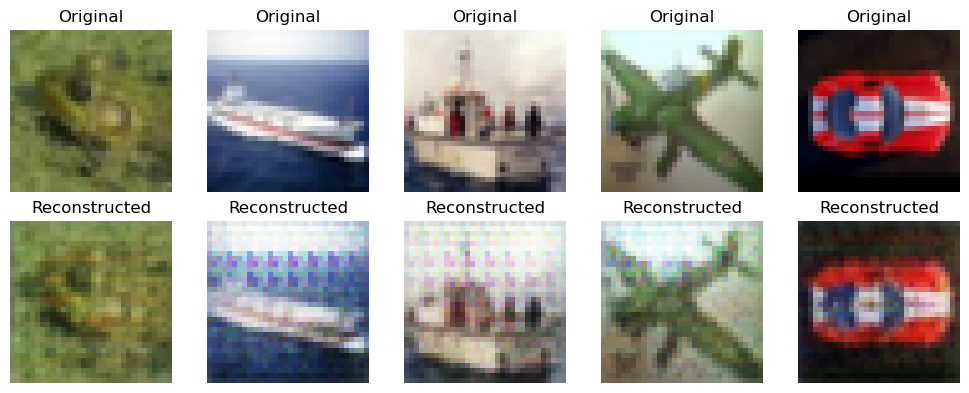

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  20/100  Batch:    1  Total Loss:  517.822  VQ Loss:  1.94585  Recon Loss:  515.876  Commitment Loss:  1.76895  Embedding Loss:  1.76895  LR:  2.7017e-06
Epoch:  20/100  Batch:  151  Total Loss:  809.262  VQ Loss:  1.96045  Recon Loss:  807.302  Commitment Loss:  1.78223  Embedding Loss:  1.78223  LR:  2.7017e-06
Epoch:  20/100  Batch:  301  Total Loss:  540.228  VQ Loss:  1.97346  Recon Loss:  538.254  Commitment Loss:  1.79405  Embedding Loss:  1.79405  LR:  2.7017e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      20 │           2.0639 │ 24.89s │
╘═════════╧══════════════════╧════════╛


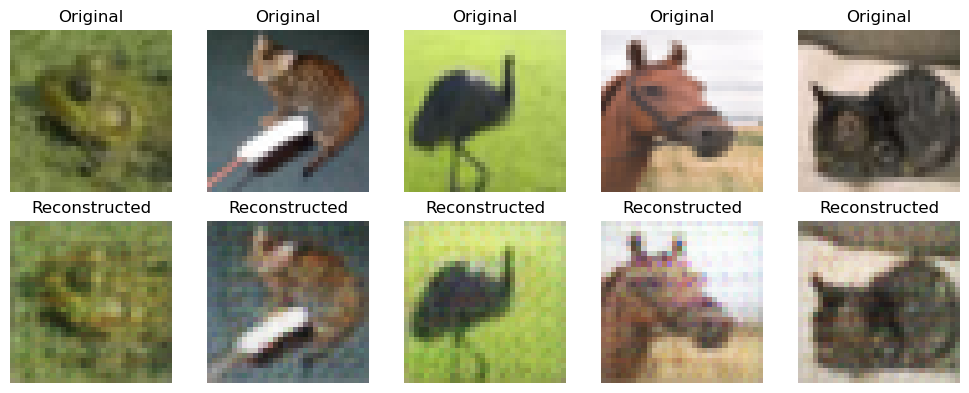

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  21/100  Batch:    1  Total Loss:  661.088  VQ Loss:  1.97054  Recon Loss:  659.117  Commitment Loss:  1.7914  Embedding Loss:  1.7914  LR:  2.43153e-06
Epoch:  21/100  Batch:  151  Total Loss:  682.465  VQ Loss:  1.95435  Recon Loss:  680.51  Commitment Loss:  1.77669  Embedding Loss:  1.77669  LR:  2.43153e-06
Epoch:  21/100  Batch:  301  Total Loss:  614.933  VQ Loss:  1.98953  Recon Loss:  612.944  Commitment Loss:  1.80866  Embedding Loss:  1.80866  LR:  2.43153e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      21 │             2.01 │ 25.08s │
╘═════════╧══════════════════╧════════╛


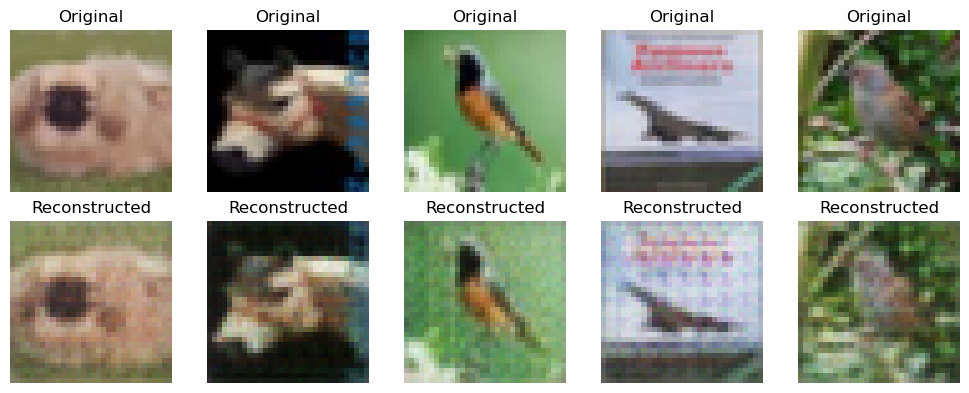

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  22/100  Batch:    1  Total Loss:  605.639  VQ Loss:  1.95807  Recon Loss:  603.681  Commitment Loss:  1.78006  Embedding Loss:  1.78006  LR:  2.18838e-06
Epoch:  22/100  Batch:  151  Total Loss:  557.775  VQ Loss:  1.98537  Recon Loss:  555.789  Commitment Loss:  1.80488  Embedding Loss:  1.80488  LR:  2.18838e-06
Epoch:  22/100  Batch:  301  Total Loss:  634.098  VQ Loss:  1.9683  Recon Loss:  632.13  Commitment Loss:  1.78936  Embedding Loss:  1.78936  LR:  2.18838e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      22 │           1.9813 │ 24.83s │
╘═════════╧══════════════════╧════════╛


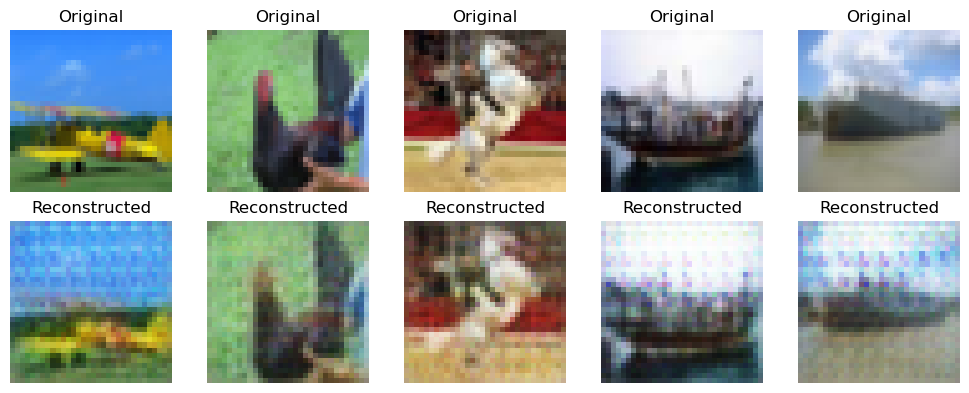

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  23/100  Batch:    1  Total Loss:  570.029  VQ Loss:  1.97176  Recon Loss:  568.058  Commitment Loss:  1.79251  Embedding Loss:  1.79251  LR:  1.96954e-06
Epoch:  23/100  Batch:  151  Total Loss:  625.033  VQ Loss:  1.939  Recon Loss:  623.094  Commitment Loss:  1.76273  Embedding Loss:  1.76273  LR:  1.96954e-06
Epoch:  23/100  Batch:  301  Total Loss:  639.517  VQ Loss:  1.9853  Recon Loss:  637.531  Commitment Loss:  1.80482  Embedding Loss:  1.80482  LR:  1.96954e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      23 │           1.8419 │ 24.84s │
╘═════════╧══════════════════╧════════╛


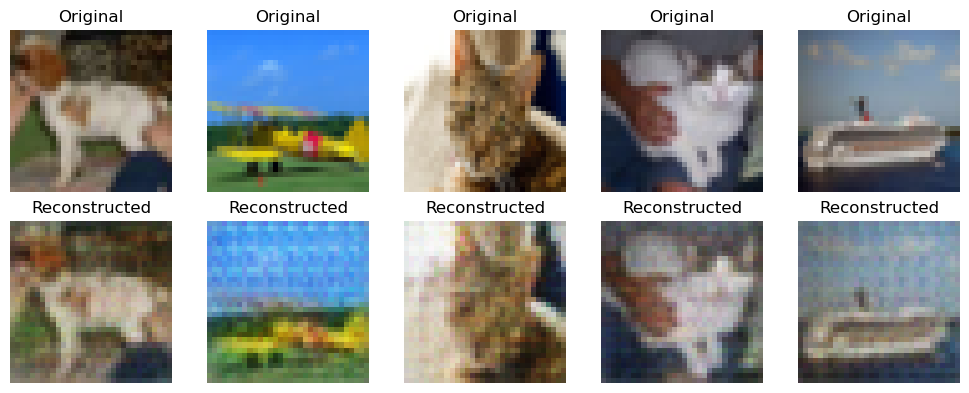

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  24/100  Batch:    1  Total Loss:  583.887  VQ Loss:  1.95394  Recon Loss:  581.933  Commitment Loss:  1.77631  Embedding Loss:  1.77631  LR:  1.77259e-06
Epoch:  24/100  Batch:  151  Total Loss:  555.721  VQ Loss:  1.97213  Recon Loss:  553.749  Commitment Loss:  1.79285  Embedding Loss:  1.79285  LR:  1.77259e-06
Epoch:  24/100  Batch:  301  Total Loss:  542.969  VQ Loss:  1.9736  Recon Loss:  540.996  Commitment Loss:  1.79418  Embedding Loss:  1.79418  LR:  1.77259e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      24 │           1.9252 │ 24.74s │
╘═════════╧══════════════════╧════════╛


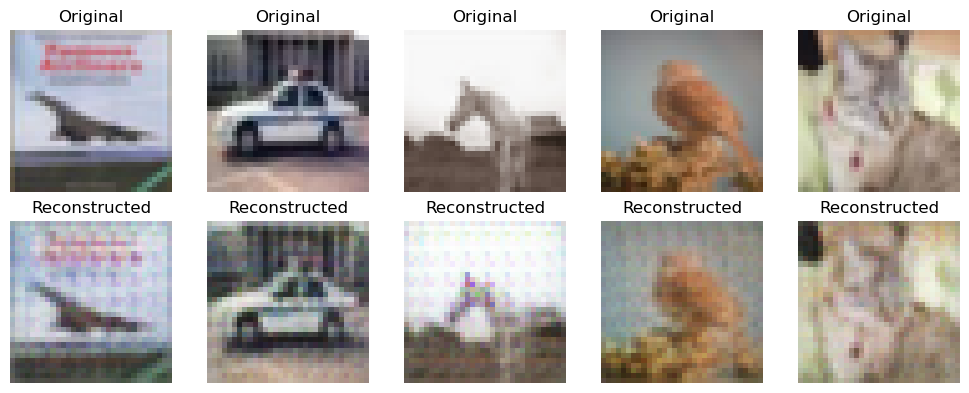

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  25/100  Batch:    1  Total Loss:  918.857  VQ Loss:  1.99859  Recon Loss:  916.858  Commitment Loss:  1.8169  Embedding Loss:  1.8169  LR:  1.59533e-06
Epoch:  25/100  Batch:  151  Total Loss:  547.864  VQ Loss:  1.98587  Recon Loss:  545.878  Commitment Loss:  1.80534  Embedding Loss:  1.80534  LR:  1.59533e-06
Epoch:  25/100  Batch:  301  Total Loss:  584.843  VQ Loss:  1.97303  Recon Loss:  582.87  Commitment Loss:  1.79366  Embedding Loss:  1.79366  LR:  1.59533e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      25 │           1.9514 │ 25.51s │
╘═════════╧══════════════════╧════════╛


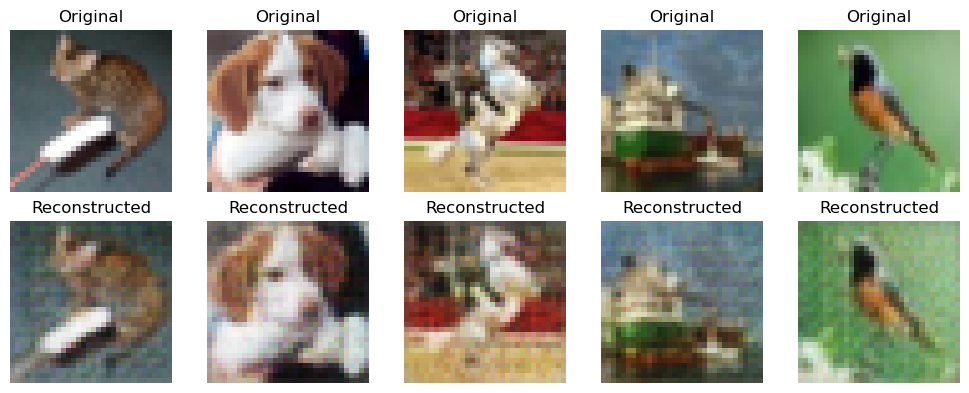

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  26/100  Batch:    1  Total Loss:  569.634  VQ Loss:  1.9489  Recon Loss:  567.686  Commitment Loss:  1.77172  Embedding Loss:  1.77172  LR:  1.4358e-06
Epoch:  26/100  Batch:  151  Total Loss:  601.193  VQ Loss:  1.96891  Recon Loss:  599.224  Commitment Loss:  1.78992  Embedding Loss:  1.78992  LR:  1.4358e-06
Epoch:  26/100  Batch:  301  Total Loss:  519.09  VQ Loss:  1.99216  Recon Loss:  517.098  Commitment Loss:  1.81106  Embedding Loss:  1.81106  LR:  1.4358e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      26 │           1.9466 │ 25.59s │
╘═════════╧══════════════════╧════════╛


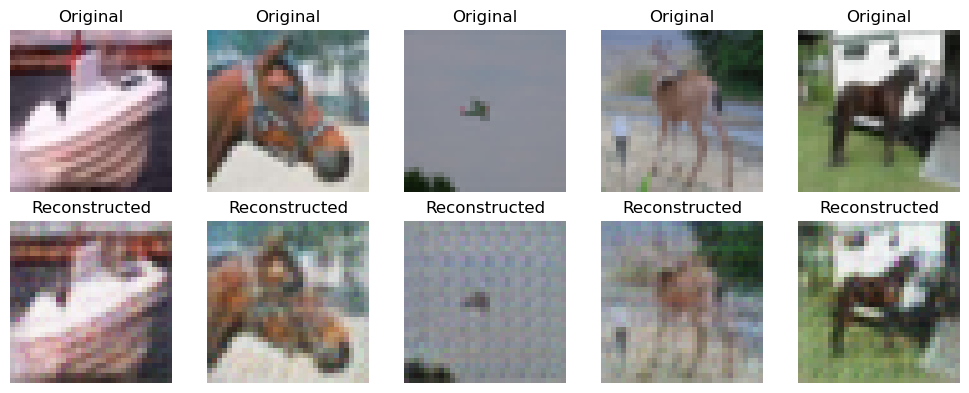

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  27/100  Batch:    1  Total Loss:  581.274  VQ Loss:  1.96969  Recon Loss:  579.304  Commitment Loss:  1.79063  Embedding Loss:  1.79063  LR:  1.29222e-06
Epoch:  27/100  Batch:  151  Total Loss:  546.964  VQ Loss:  1.97845  Recon Loss:  544.985  Commitment Loss:  1.79859  Embedding Loss:  1.79859  LR:  1.29222e-06
Epoch:  27/100  Batch:  301  Total Loss:  570.493  VQ Loss:  1.94088  Recon Loss:  568.552  Commitment Loss:  1.76444  Embedding Loss:  1.76444  LR:  1.29222e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      27 │           2.0146 │ 25.82s │
╘═════════╧══════════════════╧════════╛


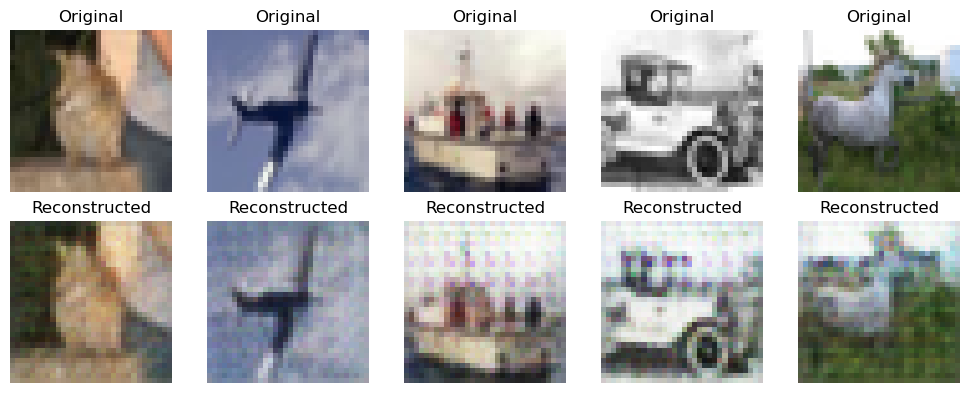

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  28/100  Batch:    1  Total Loss:  529.642  VQ Loss:  1.98913  Recon Loss:  527.653  Commitment Loss:  1.8083  Embedding Loss:  1.8083  LR:  1.16299e-06
Epoch:  28/100  Batch:  151  Total Loss:  816.814  VQ Loss:  2.00994  Recon Loss:  814.804  Commitment Loss:  1.82722  Embedding Loss:  1.82722  LR:  1.16299e-06
Epoch:  28/100  Batch:  301  Total Loss:  621.731  VQ Loss:  1.95195  Recon Loss:  619.779  Commitment Loss:  1.7745  Embedding Loss:  1.7745  LR:  1.16299e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      28 │           1.9573 │ 25.70s │
╘═════════╧══════════════════╧════════╛


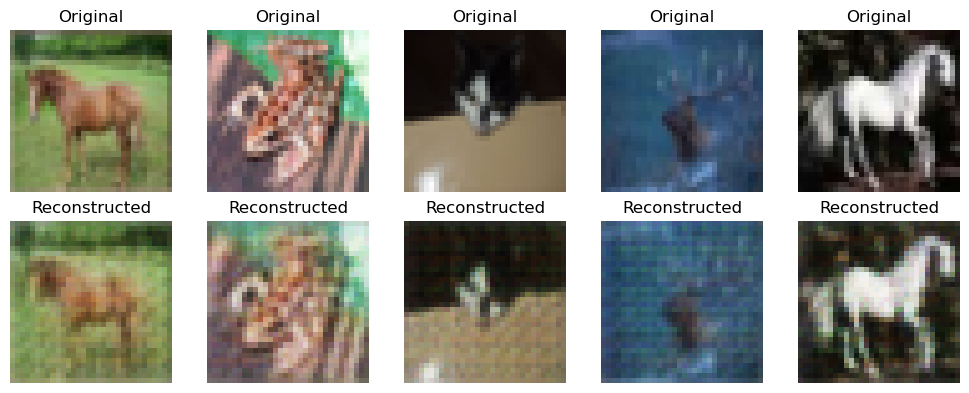

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  29/100  Batch:    1  Total Loss:  569.387  VQ Loss:  1.93189  Recon Loss:  567.455  Commitment Loss:  1.75626  Embedding Loss:  1.75626  LR:  1.0467e-06
Epoch:  29/100  Batch:  151  Total Loss:  507.313  VQ Loss:  1.96644  Recon Loss:  505.346  Commitment Loss:  1.78767  Embedding Loss:  1.78767  LR:  1.0467e-06
Epoch:  29/100  Batch:  301  Total Loss:  552.209  VQ Loss:  1.94585  Recon Loss:  550.263  Commitment Loss:  1.76896  Embedding Loss:  1.76896  LR:  1.0467e-06
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      29 │            1.897 │ 25.36s │
╘═════════╧══════════════════╧════════╛


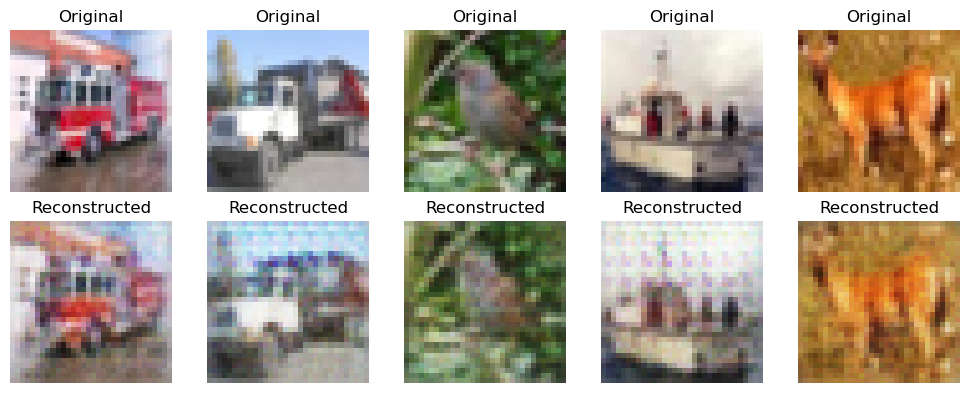

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  30/100  Batch:    1  Total Loss:  540.498  VQ Loss:  1.9661  Recon Loss:  538.532  Commitment Loss:  1.78737  Embedding Loss:  1.78737  LR:  9.42026e-07
Epoch:  30/100  Batch:  151  Total Loss:  577.247  VQ Loss:  1.97772  Recon Loss:  575.269  Commitment Loss:  1.79793  Embedding Loss:  1.79793  LR:  9.42026e-07
Epoch:  30/100  Batch:  301  Total Loss:  520.423  VQ Loss:  1.97655  Recon Loss:  518.446  Commitment Loss:  1.79687  Embedding Loss:  1.79687  LR:  9.42026e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      30 │           2.0853 │ 26.20s │
╘═════════╧══════════════════╧════════╛


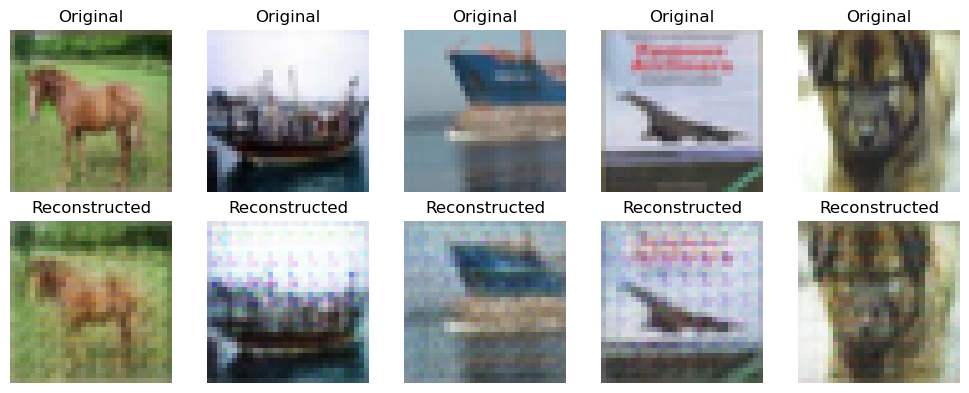

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  31/100  Batch:    1  Total Loss:  553.061  VQ Loss:  1.98914  Recon Loss:  551.072  Commitment Loss:  1.80831  Embedding Loss:  1.80831  LR:  8.47823e-07
Epoch:  31/100  Batch:  151  Total Loss:  578.505  VQ Loss:  1.96519  Recon Loss:  576.539  Commitment Loss:  1.78654  Embedding Loss:  1.78654  LR:  8.47823e-07
Epoch:  31/100  Batch:  301  Total Loss:  553.19  VQ Loss:  1.96261  Recon Loss:  551.227  Commitment Loss:  1.78419  Embedding Loss:  1.78419  LR:  8.47823e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      31 │           1.9636 │ 25.61s │
╘═════════╧══════════════════╧════════╛


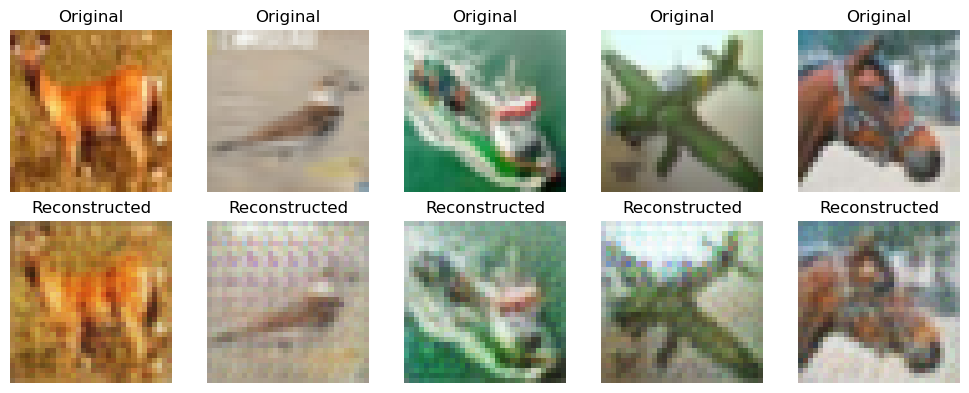

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  32/100  Batch:    1  Total Loss:  532.718  VQ Loss:  1.9922  Recon Loss:  530.726  Commitment Loss:  1.81109  Embedding Loss:  1.81109  LR:  7.63041e-07
Epoch:  32/100  Batch:  151  Total Loss:  585.73  VQ Loss:  1.97416  Recon Loss:  583.756  Commitment Loss:  1.79469  Embedding Loss:  1.79469  LR:  7.63041e-07
Epoch:  32/100  Batch:  301  Total Loss:  524.957  VQ Loss:  1.96036  Recon Loss:  522.996  Commitment Loss:  1.78214  Embedding Loss:  1.78214  LR:  7.63041e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      32 │           1.9988 │ 25.88s │
╘═════════╧══════════════════╧════════╛


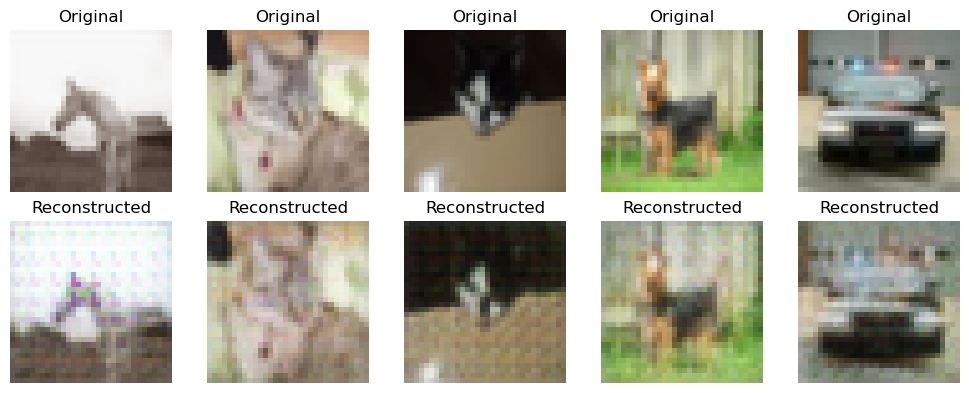

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  33/100  Batch:    1  Total Loss:  547.721  VQ Loss:  1.99506  Recon Loss:  545.725  Commitment Loss:  1.81369  Embedding Loss:  1.81369  LR:  6.86737e-07
Epoch:  33/100  Batch:  151  Total Loss:  511.599  VQ Loss:  1.97266  Recon Loss:  509.626  Commitment Loss:  1.79333  Embedding Loss:  1.79333  LR:  6.86737e-07
Epoch:  33/100  Batch:  301  Total Loss:  575.374  VQ Loss:  1.95846  Recon Loss:  573.416  Commitment Loss:  1.78042  Embedding Loss:  1.78042  LR:  6.86737e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      33 │           2.0264 │ 25.99s │
╘═════════╧══════════════════╧════════╛


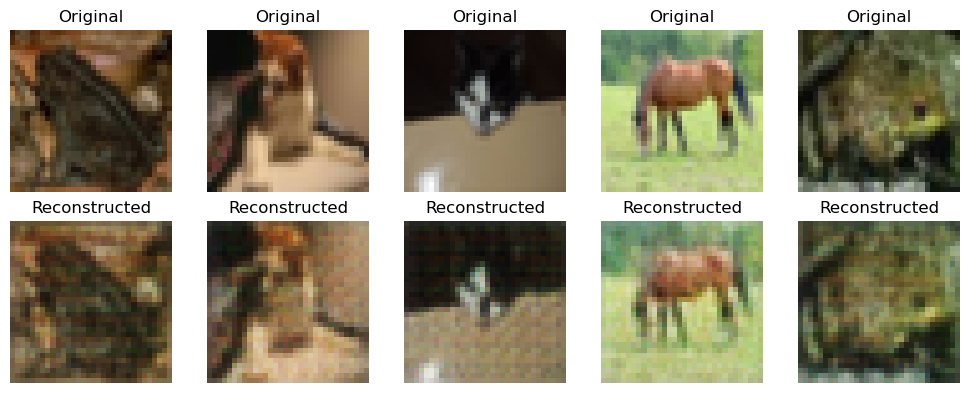

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  34/100  Batch:    1  Total Loss:  713.975  VQ Loss:  1.97032  Recon Loss:  712.005  Commitment Loss:  1.7912  Embedding Loss:  1.7912  LR:  6.18063e-07
Epoch:  34/100  Batch:  151  Total Loss:  534.483  VQ Loss:  2.0082  Recon Loss:  532.475  Commitment Loss:  1.82564  Embedding Loss:  1.82564  LR:  6.18063e-07
Epoch:  34/100  Batch:  301  Total Loss:  658.165  VQ Loss:  1.98525  Recon Loss:  656.18  Commitment Loss:  1.80477  Embedding Loss:  1.80477  LR:  6.18063e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      34 │           2.0332 │ 25.53s │
╘═════════╧══════════════════╧════════╛


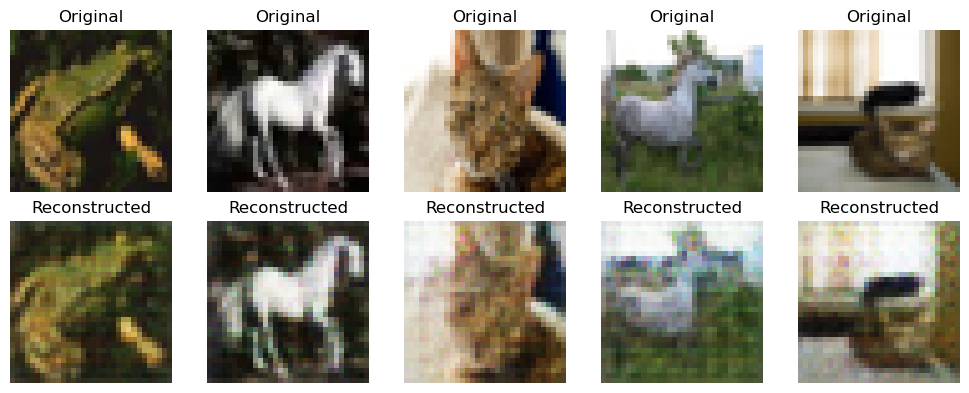

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  35/100  Batch:    1  Total Loss:  500.851  VQ Loss:  1.99119  Recon Loss:  498.86  Commitment Loss:  1.81018  Embedding Loss:  1.81018  LR:  5.56257e-07
Epoch:  35/100  Batch:  151  Total Loss:  645.471  VQ Loss:  1.97594  Recon Loss:  643.495  Commitment Loss:  1.79631  Embedding Loss:  1.79631  LR:  5.56257e-07
Epoch:  35/100  Batch:  301  Total Loss:  520.042  VQ Loss:  1.95635  Recon Loss:  518.085  Commitment Loss:  1.7785  Embedding Loss:  1.7785  LR:  5.56257e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      35 │           1.9518 │ 25.88s │
╘═════════╧══════════════════╧════════╛


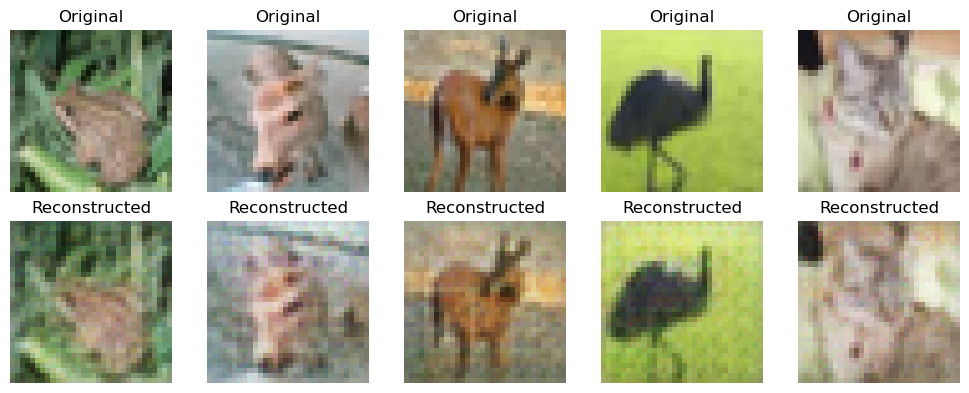

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  36/100  Batch:    1  Total Loss:  480.965  VQ Loss:  1.97389  Recon Loss:  478.991  Commitment Loss:  1.79445  Embedding Loss:  1.79445  LR:  5.00631e-07
Epoch:  36/100  Batch:  151  Total Loss:  622.674  VQ Loss:  1.94206  Recon Loss:  620.732  Commitment Loss:  1.76551  Embedding Loss:  1.76551  LR:  5.00631e-07
Epoch:  36/100  Batch:  301  Total Loss:  531.36  VQ Loss:  1.97353  Recon Loss:  529.387  Commitment Loss:  1.79412  Embedding Loss:  1.79412  LR:  5.00631e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      36 │           1.9247 │ 21.74s │
╘═════════╧══════════════════╧════════╛


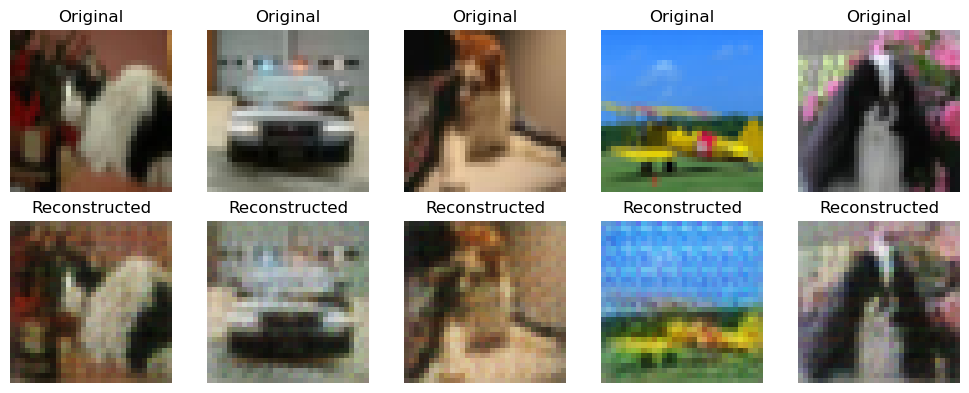

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  37/100  Batch:    1  Total Loss:  525.073  VQ Loss:  1.9813  Recon Loss:  523.091  Commitment Loss:  1.80118  Embedding Loss:  1.80118  LR:  4.50568e-07
Epoch:  37/100  Batch:  151  Total Loss:  498.359  VQ Loss:  1.96527  Recon Loss:  496.393  Commitment Loss:  1.78661  Embedding Loss:  1.78661  LR:  4.50568e-07
Epoch:  37/100  Batch:  301  Total Loss:  831.766  VQ Loss:  1.97965  Recon Loss:  829.786  Commitment Loss:  1.79969  Embedding Loss:  1.79969  LR:  4.50568e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      37 │           1.9483 │ 22.24s │
╘═════════╧══════════════════╧════════╛


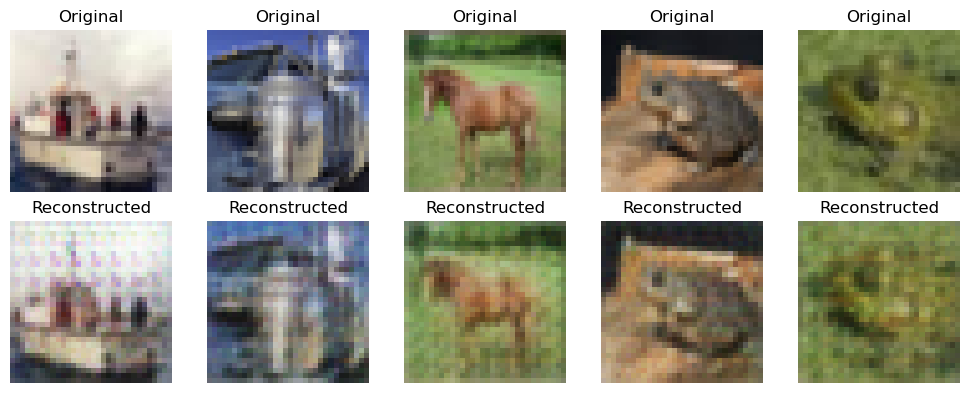

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  38/100  Batch:    1  Total Loss:  552.894  VQ Loss:  2.01622  Recon Loss:  550.878  Commitment Loss:  1.83292  Embedding Loss:  1.83292  LR:  4.05511e-07
Epoch:  38/100  Batch:  151  Total Loss:  598.116  VQ Loss:  1.97744  Recon Loss:  596.138  Commitment Loss:  1.79767  Embedding Loss:  1.79767  LR:  4.05511e-07
Epoch:  38/100  Batch:  301  Total Loss:  1088.06  VQ Loss:  2.01295  Recon Loss:  1086.05  Commitment Loss:  1.82996  Embedding Loss:  1.82996  LR:  4.05511e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      38 │           1.9724 │ 21.62s │
╘═════════╧══════════════════╧════════╛


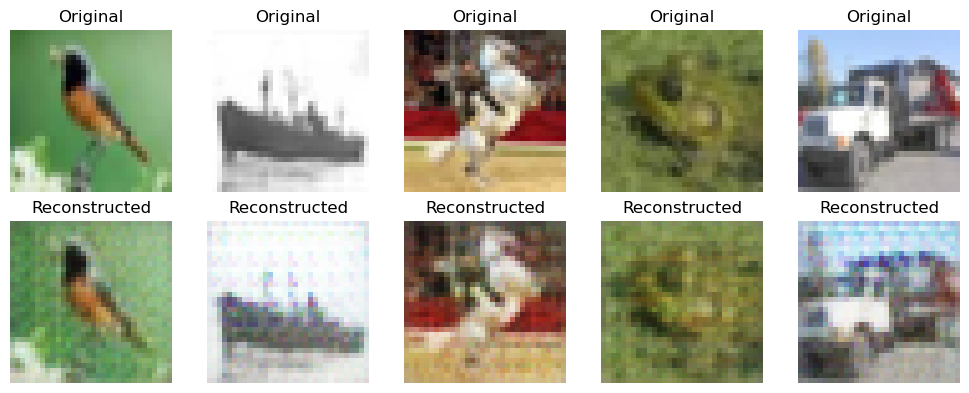

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  39/100  Batch:    1  Total Loss:  533.988  VQ Loss:  1.96893  Recon Loss:  532.019  Commitment Loss:  1.78994  Embedding Loss:  1.78994  LR:  3.6496e-07
Epoch:  39/100  Batch:  151  Total Loss:  674.366  VQ Loss:  1.97045  Recon Loss:  672.396  Commitment Loss:  1.79132  Embedding Loss:  1.79132  LR:  3.6496e-07
Epoch:  39/100  Batch:  301  Total Loss:  501.114  VQ Loss:  1.98028  Recon Loss:  499.134  Commitment Loss:  1.80026  Embedding Loss:  1.80026  LR:  3.6496e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      39 │           1.8969 │ 21.12s │
╘═════════╧══════════════════╧════════╛


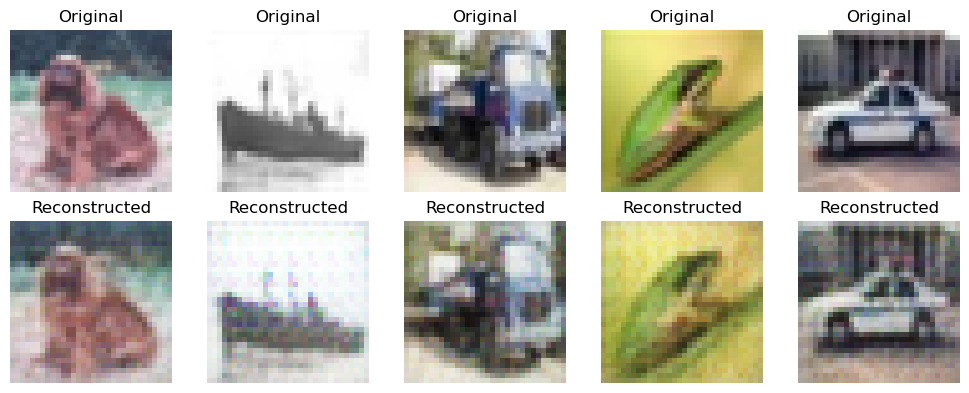

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  40/100  Batch:    1  Total Loss:  507.045  VQ Loss:  1.98986  Recon Loss:  505.055  Commitment Loss:  1.80896  Embedding Loss:  1.80896  LR:  3.28464e-07
Epoch:  40/100  Batch:  151  Total Loss:  599.192  VQ Loss:  1.97517  Recon Loss:  597.217  Commitment Loss:  1.79561  Embedding Loss:  1.79561  LR:  3.28464e-07
Epoch:  40/100  Batch:  301  Total Loss:  525.441  VQ Loss:  1.97355  Recon Loss:  523.467  Commitment Loss:  1.79414  Embedding Loss:  1.79414  LR:  3.28464e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      40 │           2.1192 │ 21.93s │
╘═════════╧══════════════════╧════════╛


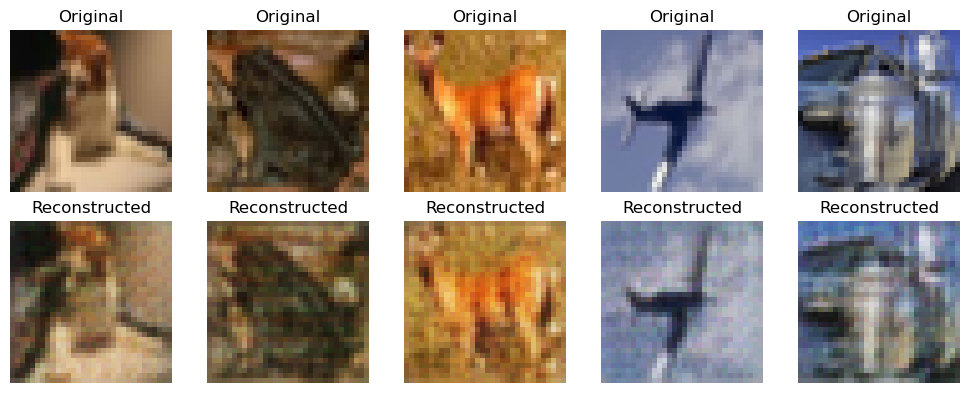

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  41/100  Batch:    1  Total Loss:  564.692  VQ Loss:  1.99315  Recon Loss:  562.699  Commitment Loss:  1.81195  Embedding Loss:  1.81195  LR:  2.95618e-07
Epoch:  41/100  Batch:  151  Total Loss:  524.021  VQ Loss:  1.99148  Recon Loss:  522.029  Commitment Loss:  1.81044  Embedding Loss:  1.81044  LR:  2.95618e-07
Epoch:  41/100  Batch:  301  Total Loss:  490.997  VQ Loss:  1.98133  Recon Loss:  489.016  Commitment Loss:  1.80121  Embedding Loss:  1.80121  LR:  2.95618e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      41 │           2.0025 │ 21.59s │
╘═════════╧══════════════════╧════════╛


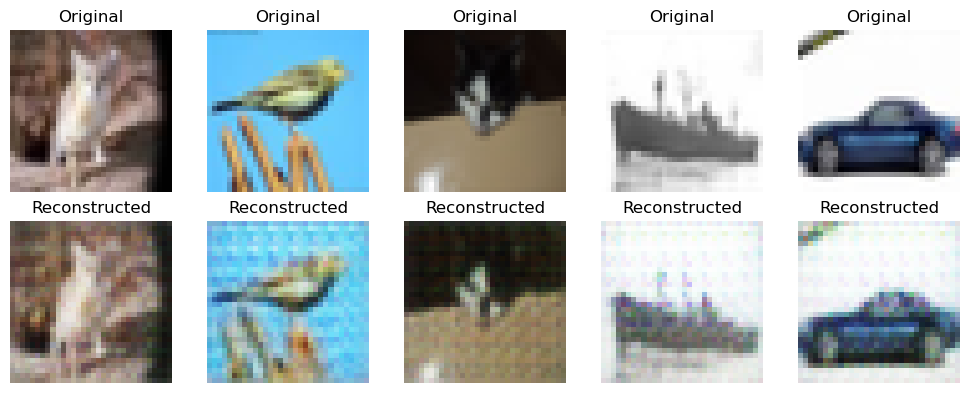

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  42/100  Batch:    1  Total Loss:  571.383  VQ Loss:  1.98032  Recon Loss:  569.402  Commitment Loss:  1.80029  Embedding Loss:  1.80029  LR:  2.66056e-07
Epoch:  42/100  Batch:  151  Total Loss:  509.315  VQ Loss:  1.96536  Recon Loss:  507.349  Commitment Loss:  1.78669  Embedding Loss:  1.78669  LR:  2.66056e-07
Epoch:  42/100  Batch:  301  Total Loss:  512.754  VQ Loss:  1.98002  Recon Loss:  510.774  Commitment Loss:  1.80002  Embedding Loss:  1.80002  LR:  2.66056e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      42 │           1.9463 │ 21.70s │
╘═════════╧══════════════════╧════════╛


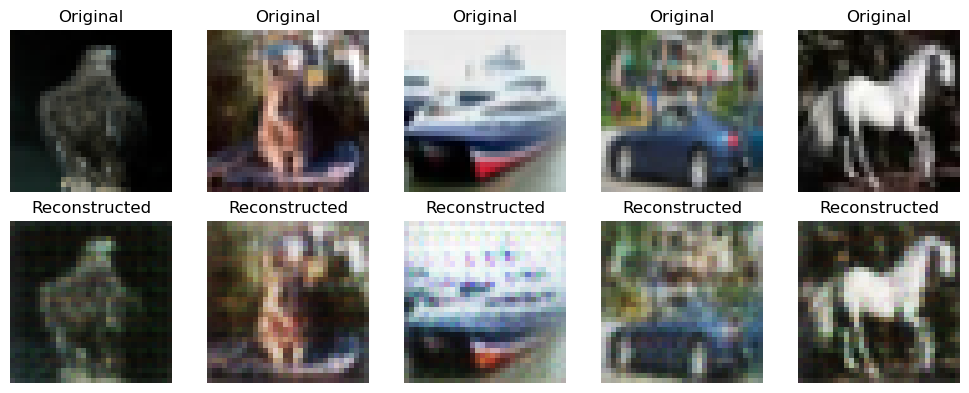

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  43/100  Batch:    1  Total Loss:  529.726  VQ Loss:  1.97752  Recon Loss:  527.748  Commitment Loss:  1.79775  Embedding Loss:  1.79775  LR:  2.3945e-07
Epoch:  43/100  Batch:  151  Total Loss:  497.517  VQ Loss:  1.97831  Recon Loss:  495.539  Commitment Loss:  1.79847  Embedding Loss:  1.79847  LR:  2.3945e-07
Epoch:  43/100  Batch:  301  Total Loss:  602.669  VQ Loss:  1.98282  Recon Loss:  600.686  Commitment Loss:  1.80257  Embedding Loss:  1.80257  LR:  2.3945e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      43 │           1.9937 │ 21.44s │
╘═════════╧══════════════════╧════════╛


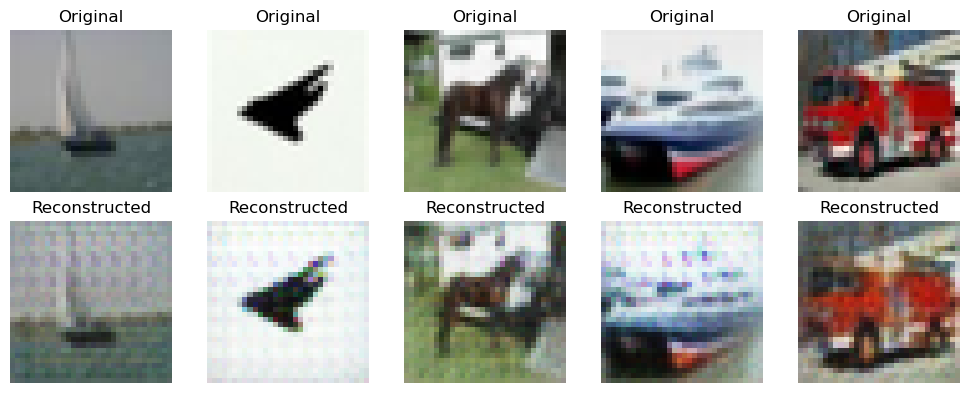

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  44/100  Batch:    1  Total Loss:  493.701  VQ Loss:  1.9943  Recon Loss:  491.706  Commitment Loss:  1.813  Embedding Loss:  1.813  LR:  2.15505e-07
Epoch:  44/100  Batch:  151  Total Loss:  563.502  VQ Loss:  1.9868  Recon Loss:  561.515  Commitment Loss:  1.80618  Embedding Loss:  1.80618  LR:  2.15505e-07
Epoch:  44/100  Batch:  301  Total Loss:  549.29  VQ Loss:  1.9456  Recon Loss:  547.344  Commitment Loss:  1.76873  Embedding Loss:  1.76873  LR:  2.15505e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      44 │           1.8892 │ 21.41s │
╘═════════╧══════════════════╧════════╛


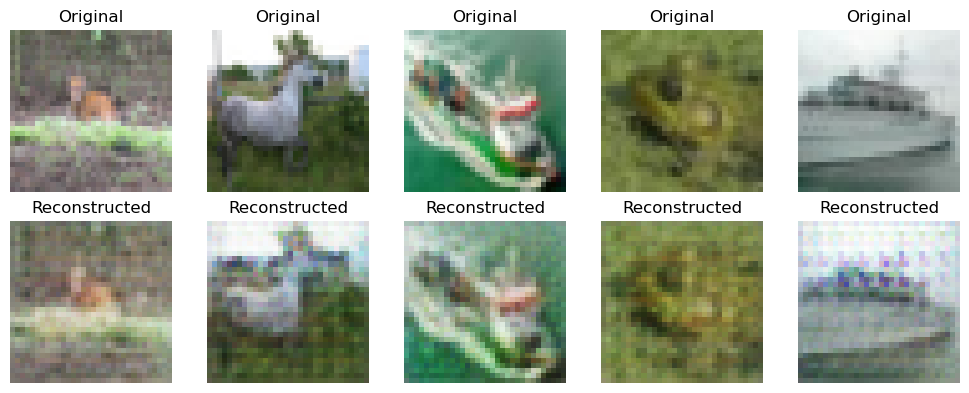

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  45/100  Batch:    1  Total Loss:  645.596  VQ Loss:  1.93467  Recon Loss:  643.661  Commitment Loss:  1.75879  Embedding Loss:  1.75879  LR:  1.93955e-07
Epoch:  45/100  Batch:  151  Total Loss:  507.593  VQ Loss:  1.95771  Recon Loss:  505.635  Commitment Loss:  1.77974  Embedding Loss:  1.77974  LR:  1.93955e-07
Epoch:  45/100  Batch:  301  Total Loss:  523.497  VQ Loss:  1.97029  Recon Loss:  521.527  Commitment Loss:  1.79118  Embedding Loss:  1.79118  LR:  1.93955e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      45 │           1.9382 │ 25.82s │
╘═════════╧══════════════════╧════════╛


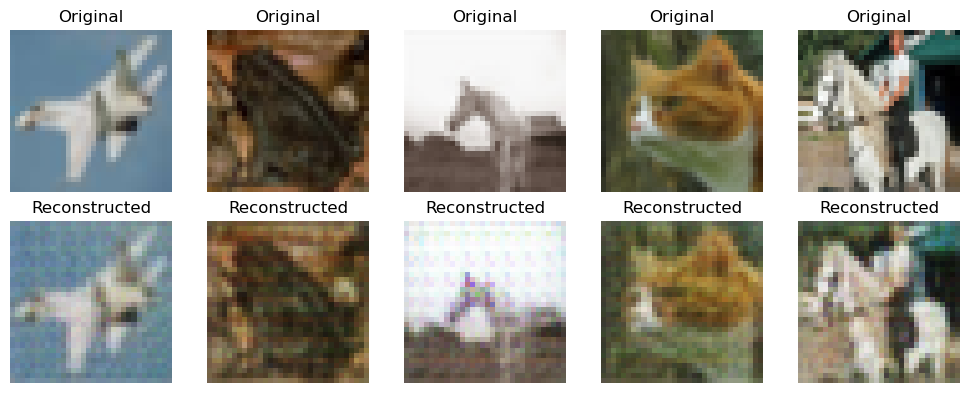

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  46/100  Batch:    1  Total Loss:  569.056  VQ Loss:  1.99284  Recon Loss:  567.063  Commitment Loss:  1.81167  Embedding Loss:  1.81167  LR:  1.74559e-07
Epoch:  46/100  Batch:  151  Total Loss:  509.269  VQ Loss:  1.98665  Recon Loss:  507.283  Commitment Loss:  1.80604  Embedding Loss:  1.80604  LR:  1.74559e-07
Epoch:  46/100  Batch:  301  Total Loss:  565.032  VQ Loss:  1.98948  Recon Loss:  563.043  Commitment Loss:  1.80862  Embedding Loss:  1.80862  LR:  1.74559e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      46 │           2.0384 │ 21.19s │
╘═════════╧══════════════════╧════════╛


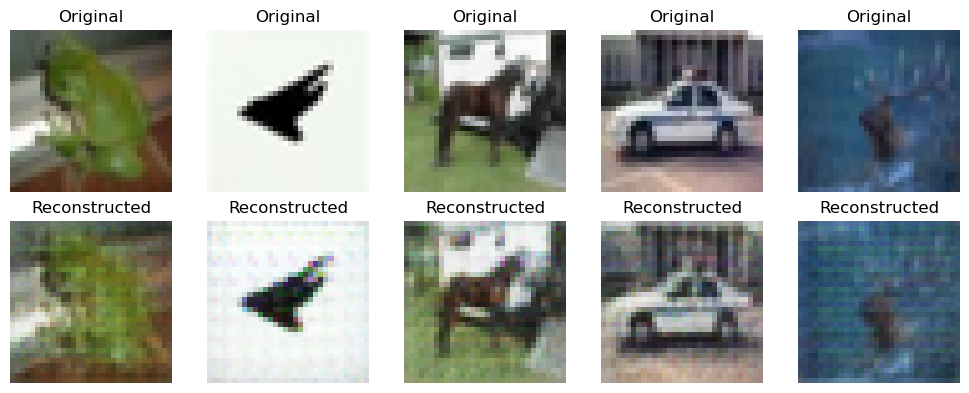

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  47/100  Batch:    1  Total Loss:  507.247  VQ Loss:  1.9873  Recon Loss:  505.259  Commitment Loss:  1.80663  Embedding Loss:  1.80663  LR:  1.57103e-07
Epoch:  47/100  Batch:  151  Total Loss:  610.916  VQ Loss:  1.99617  Recon Loss:  608.92  Commitment Loss:  1.8147  Embedding Loss:  1.8147  LR:  1.57103e-07
Epoch:  47/100  Batch:  301  Total Loss:  474.847  VQ Loss:  1.98855  Recon Loss:  472.859  Commitment Loss:  1.80778  Embedding Loss:  1.80778  LR:  1.57103e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      47 │           1.9697 │ 21.79s │
╘═════════╧══════════════════╧════════╛


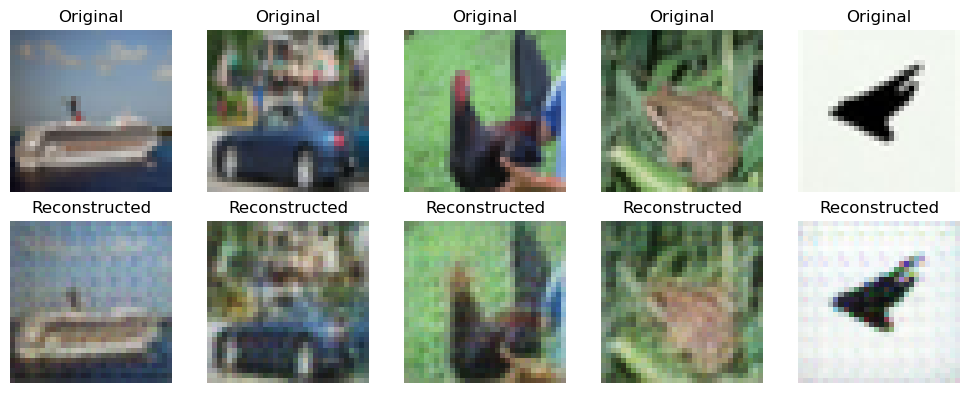

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  48/100  Batch:    1  Total Loss:  599.287  VQ Loss:  1.97504  Recon Loss:  597.312  Commitment Loss:  1.7955  Embedding Loss:  1.7955  LR:  1.41393e-07
Epoch:  48/100  Batch:  151  Total Loss:  521.561  VQ Loss:  2.00268  Recon Loss:  519.558  Commitment Loss:  1.82061  Embedding Loss:  1.82061  LR:  1.41393e-07
Epoch:  48/100  Batch:  301  Total Loss:  550.471  VQ Loss:  2.00734  Recon Loss:  548.463  Commitment Loss:  1.82485  Embedding Loss:  1.82485  LR:  1.41393e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      48 │           1.9453 │ 21.23s │
╘═════════╧══════════════════╧════════╛


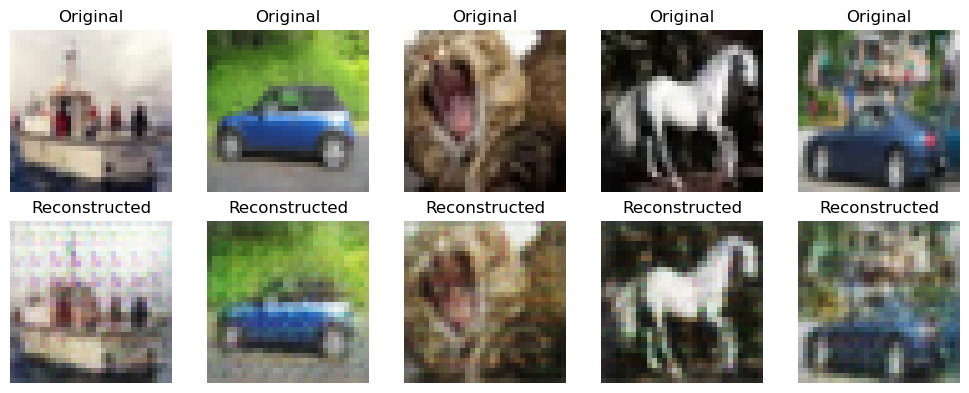

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  49/100  Batch:    1  Total Loss:  518.721  VQ Loss:  1.96943  Recon Loss:  516.752  Commitment Loss:  1.79039  Embedding Loss:  1.79039  LR:  1.27254e-07
Epoch:  49/100  Batch:  151  Total Loss:  452.789  VQ Loss:  1.95729  Recon Loss:  450.832  Commitment Loss:  1.77936  Embedding Loss:  1.77936  LR:  1.27254e-07
Epoch:  49/100  Batch:  301  Total Loss:  631.924  VQ Loss:  1.9914  Recon Loss:  629.933  Commitment Loss:  1.81037  Embedding Loss:  1.81037  LR:  1.27254e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      49 │           1.9827 │ 21.24s │
╘═════════╧══════════════════╧════════╛


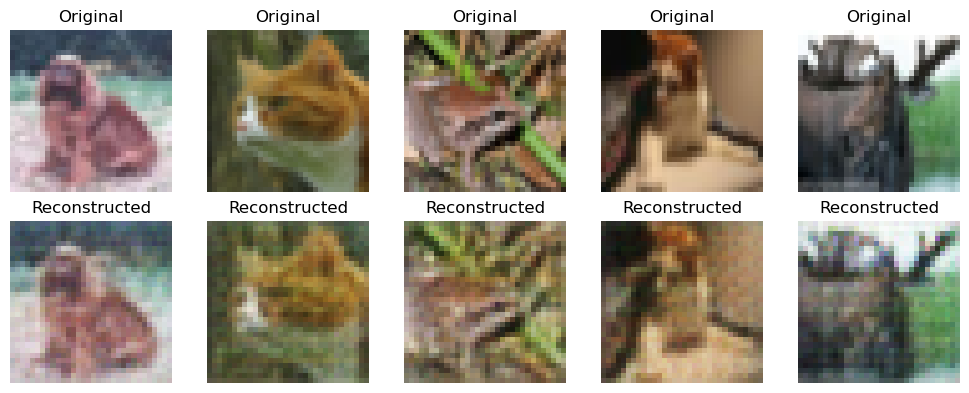

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  50/100  Batch:    1  Total Loss:  495.013  VQ Loss:  1.97434  Recon Loss:  493.038  Commitment Loss:  1.79486  Embedding Loss:  1.79486  LR:  1.14528e-07
Epoch:  50/100  Batch:  151  Total Loss:  547.147  VQ Loss:  1.98812  Recon Loss:  545.159  Commitment Loss:  1.80738  Embedding Loss:  1.80738  LR:  1.14528e-07
Epoch:  50/100  Batch:  301  Total Loss:  574.19  VQ Loss:  1.97557  Recon Loss:  572.214  Commitment Loss:  1.79597  Embedding Loss:  1.79597  LR:  1.14528e-07
╒═════════╤══════════════════╤════════╕
│   Epoch │   Mean Test Loss │ Time   │
╞═════════╪══════════════════╪════════╡
│      50 │           1.9914 │ 21.43s │
╘═════════╧══════════════════╧════════╛


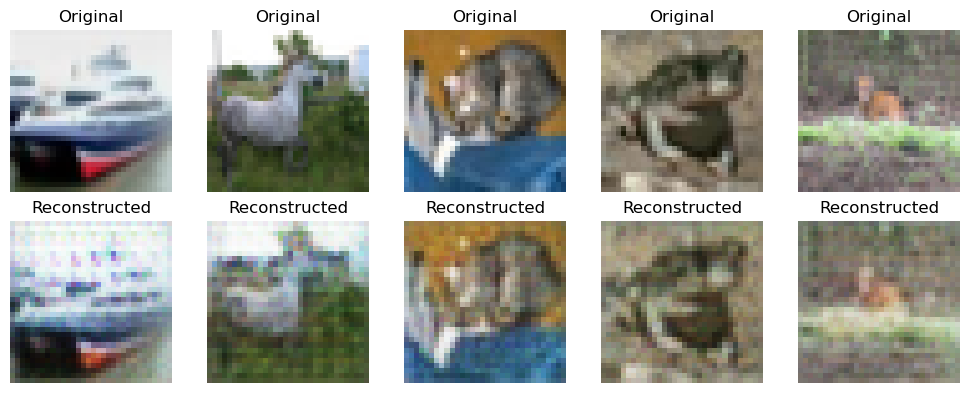

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [4]:

import time
import torch
import torch.nn.functional as F
from tabulate import tabulate

# Initialize lists for tracking losses and learning rates
train_losses = []
test_losses = []
learning_rates = []
reconstruction_losses = []
vq_losses = []
commitment_losses = []
embedding_losses = []

# Training loop
for epoch in range(num_epochs):
    print('-----------------------------------------------------------------------------------------------------------------------------')
    model.train()
    batch_recon_losses = []
    batch_vq_losses = []
    batch_commitment_losses = []
    batch_embedding_losses = []
    batch_total_losses = []
    epoch_start_time = time.time()  # Start of time measurement

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            # Forward pass
            recon_batch, vqloss, embedding_loss, commitment_loss = model(data)
            recon_loss = F.mse_loss(recon_batch, data, reduction='sum')
            loss = vqloss + recon_loss

        # Backward pass
        scaler.scale(loss).backward()
        
        scaler.step(optimizer)
        scaler.update()

        # Save the loss values for the current batch
        curr_loss = loss.detach().item()
        curr_vqloss = vqloss.detach().item()
        curr_recon_loss = recon_loss.detach().item()
        curr_commitment_loss = commitment_loss.detach().item()
        curr_embedding_loss = embedding_loss.detach().item()
        batch_total_losses.append(curr_loss)
        batch_vq_losses.append(curr_vqloss)
        batch_recon_losses.append(curr_recon_loss)
        batch_commitment_losses.append(curr_commitment_loss)
        batch_embedding_losses.append(curr_embedding_loss)

        # Log training loss and current learning rate
        if batch_idx % output_frequency == 0:
            log = [['Epoch:', f'{epoch + 1:3d}/{num_epochs:3d}', 'Batch:', f'{batch_idx + 1:3d}',
                    'Total Loss:', f'{curr_loss:.6f}', 'VQ Loss:', f'{curr_vqloss:.6f}', 
                    'Recon Loss:', f'{curr_recon_loss:.6f}', 
                    'Commitment Loss:', f'{curr_commitment_loss:.6f}', 
                    'Embedding Loss:', f'{curr_embedding_loss:.6f}', 
                    'LR:', scheduler.get_last_lr()[0]]]
            print(tabulate(log, tablefmt="plain"))

    # Step the learning rate scheduler
    if scheduler is not None:
        lr = scheduler.get_last_lr()[0]
        scheduler.step()
    else:
        lr = learning_rate
    learning_rates.append(lr)

    # After the epoch, evaluate the accuracy on the test dataset
    mean_loss = evaluate(model, test_loader, device)
    test_losses.append(mean_loss)

    # Save the average training loss
    average_total_loss = torch.tensor(batch_total_losses).mean().item()
    average_recon_loss = torch.tensor(batch_recon_losses).mean().item()
    average_vq_loss = torch.tensor(batch_vq_losses).mean().item()
    average_commitment_loss = torch.tensor(batch_commitment_losses).mean().item()
    average_embedding_loss = torch.tensor(batch_embedding_losses).mean().item()
    train_losses.append(average_total_loss)
    reconstruction_losses.append(average_recon_loss)
    vq_losses.append(average_vq_loss)
    commitment_losses.append(average_commitment_loss)
    embedding_losses.append(average_embedding_loss)

    # End of time measurement
    elapsed_time = time.time() - epoch_start_time

    # Log epoch results
    headers = ["Epoch", "Mean Test Loss", "Time"]
    data = [[epoch + 1, f"{mean_loss:.4f}", f"{elapsed_time:.2f}s"]]
    print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

    # Generate reconstructed test images after each epoch
    plot_reconstruction(model, test_loader, device, num_samples=5)
    print('-----------------------------------------------------------------------------------------------------------------------------')

# Plot Train Loss & Test Loss & LR
plot_loss_lr(num_epochs, train_losses, test_losses, learning_rates)

# Plot each loss component
plot_loss_components(reconstruction_losses, vq_losses)

# Sample some VAE-generated images
sample(model, device, latent_dim, num_samples=50)
